## I. Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor

## II. Data Preprocessing

1. Load the Dataset

Should load data manually by uploading a csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
# df = pd.read_csv('/content/drive/MyDrive/heart_2020_cleaned.csv')
df = pd.read_csv('/content/drive/MyDrive/MISC/heart_2020_cleaned.csv')
# Display the first few rows of the dataset
df.head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  
3               No       Good        6.0     No            No        Yes  
4              Yes  Very good        8.0     No            No         No

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

2. Check for missing values

In [ ]:
# Check for missing values
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64


3. Convert to number

In [ ]:
df['HeartDisease'] = df['HeartDisease'].map({'Yes': 1, 'No': 0})

In [ ]:
df_processed = df.copy()

In [ ]:
binary_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

In [ ]:
for col in binary_cols:
    df_processed[col] = df_processed[col].map({'Yes': 1, 'No': 0})

In [ ]:
df_processed['Sex'] = df_processed['Sex'].map({'Male': 1, 'Female': 0})

In [ ]:
diabetic_map = {
    'No': 0,
    'No, borderline diabetes': 0.5,
    'Yes': 1,
    'Yes (during pregnancy)': 1
}
df_processed['Diabetic_num'] = df_processed['Diabetic'].map(diabetic_map)

In [ ]:
genhealth_map = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Very good': 4, 'Excellent': 5}
df_processed['GenHealth_num'] = df_processed['GenHealth'].map(genhealth_map)

In [ ]:
def age_to_midpoint(age_category):
    if 'or older' in age_category:
        return 80
    age_range = age_category.split('-')
    return (int(age_range[0]) + int(age_range[1])) / 2

df_processed['Age'] = df_processed['AgeCategory'].apply(age_to_midpoint)

In [ ]:
race_counts = df_processed['Race'].value_counts(normalize=True)
rare_races = race_counts[race_counts < 0.02].index
df_processed['Race_grouped'] = df_processed['Race'].replace(rare_races, 'Other')

In [ ]:
# Check unique values
for c in df_processed.columns:
    print(c, "-> unique:", df_processed[c].nunique(), " sample values:", df_processed[c].dropna().unique()[:8])

HeartDisease -> unique: 2  sample values: [0 1]
BMI -> unique: 3604  sample values: [16.6  20.34 26.58 24.21 23.71 28.87 21.63 31.64]
Smoking -> unique: 2  sample values: [1 0]
AlcoholDrinking -> unique: 2  sample values: [0 1]
Stroke -> unique: 2  sample values: [0 1]
PhysicalHealth -> unique: 31  sample values: [ 3.  0. 20. 28.  6. 15.  5. 30.]
MentalHealth -> unique: 31  sample values: [30.  0.  2.  5. 15.  8.  4.  3.]
DiffWalking -> unique: 2  sample values: [0 1]
Sex -> unique: 2  sample values: [0 1]
AgeCategory -> unique: 13  sample values: ['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54']
Race -> unique: 6  sample values: ['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
Diabetic -> unique: 4  sample values: ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)']
PhysicalActivity -> unique: 2  sample values: [1 0]
GenHealth -> unique: 5  sample values: ['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
SleepTime -> unique: 

4. Create new features

In [ ]:
comorbidity_cols = ['Stroke', 'DiffWalking', 'Asthma', 'KidneyDisease', 'SkinCancer']
# Thêm 'Diabetic' vào nếu người đó có bệnh (giá trị > 0)
df_processed['ComorbidityCount'] = df_processed[comorbidity_cols].sum(axis=1) + (df_processed['Diabetic_num'] > 0).astype(int)

In [ ]:
df_processed['UnhealthyDays'] = df_processed['PhysicalHealth'] + df_processed['MentalHealth']

In [ ]:
df_processed['LifestyleRisk'] = (
    df_processed['Smoking'] +
    df_processed['AlcoholDrinking'] +
    ((df_processed['SleepTime'] < 5) | (df_processed['SleepTime'] > 9)).astype(int)
)

5. Drop unnecessary features

In [ ]:
cols_to_drop = [
    'Diabetic', 'AgeCategory', 'Race', # Cột gốc đã được biến đổi
    'PhysicalHealth', 'MentalHealth', 'GenHealth' # Cột thành phần đã được gộp vào 'UnhealthyDays'
]

In [ ]:
df_final = df_processed.drop(columns=cols_to_drop)

In [ ]:
df_final.head()

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  DiffWalking  Sex  \
0             0  16.60        1                0       0            0    0   
1             0  20.34        0                0       1            0    0   
2             0  26.58        1                0       0            0    1   
3             0  24.21        0                0       0            0    0   
4             0  23.71        0                0       0            1    0   

   PhysicalActivity  SleepTime  Asthma  KidneyDisease  SkinCancer  \
0                 1        5.0       1              0           1   
1                 1        7.0       0              0           0   
2                 1        8.0       1              0           0   
3                 0        6.0       0              0           1   
4                 1        8.0       0              0           0   

   Diabetic_num  GenHealth_num   Age Race_grouped  ComorbidityCount  \
0           1.0              4  57.0        White                 3   
1           0.0              4  80.0        White                 1   
2           1.0              2  67.0        White                 2   
3           0.0              3  77.0        White                 1   
4           0.0              4  42.0        White                 1   

   UnhealthyDays  LifestyleRisk  
0           33.0              1  
1            0.0              0  
2           50.0              1  
3            0.0              0  
4           28.0              0

## III. Feature Selection

In [ ]:
X = df_final.drop('HeartDisease', axis=1)
y = df_final['HeartDisease']

In [ ]:
categorical_features = ['Race_grouped']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True, dtype=float)

In [ ]:
X.head()

BMI  Smoking  AlcoholDrinking  Stroke  DiffWalking  Sex  \
0  16.60        1                0       0            0    0   
1  20.34        0                0       1            0    0   
2  26.58        1                0       0            0    1   
3  24.21        0                0       0            0    0   
4  23.71        0                0       0            1    0   

   PhysicalActivity  SleepTime  Asthma  KidneyDisease  ...  Diabetic_num  \
0                 1        5.0       1              0  ...           1.0   
1                 1        7.0       0              0  ...           0.0   
2                 1        8.0       1              0  ...           1.0   
3                 0        6.0       0              0  ...           0.0   
4                 1        8.0       0              0  ...           0.0   

   GenHealth_num   Age  ComorbidityCount  UnhealthyDays  LifestyleRisk  \
0              4  57.0                 3           33.0              1   
1              4  80.0                 1            0.0              0   
2              2  67.0                 2           50.0              1   
3              3  77.0                 1            0.0              0   
4              4  42.0                 1           28.0              0   

   Race_grouped_Black  Race_grouped_Hispanic  Race_grouped_Other  \
0                 0.0                    0.0                 0.0   
1                 0.0                    0.0                 0.0   
2                 0.0                    0.0                 0.0   
3                 0.0                    0.0                 0.0   
4                 0.0                    0.0                 0.0   

   Race_grouped_White  
0                 1.0  
1                 1.0  
2                 1.0  
3                 1.0  
4                 1.0  

[5 rows x 21 columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
numerical_features = [
    'BMI', 'SleepTime', 'Diabetic_num', 'GenHealth_num', 'Age',
    'ComorbidityCount', 'UnhealthyDays', 'LifestyleRisk'
]

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough' # Giữ nguyên các cột còn lại (cột nhị phân và dummy)
)

In [ ]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [ ]:
new_numerical_features = numerical_features
other_features = [col for col in X.columns if col not in numerical_features]
scaled_feature_names = new_numerical_features + other_features

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=scaled_feature_names)

In [ ]:
X_train_scaled_df.head()

BMI  SleepTime  Diabetic_num  GenHealth_num       Age  \
0 -0.740760  -1.460426     -0.423462      -1.529499 -0.415273   
1 -0.928238   0.627913     -0.423462       0.388403 -1.544363   
2  0.781121  -0.068200     -0.423462      -1.529499 -1.262090   
3 -0.529650   0.627913     -0.423462       0.388403  0.713816   
4 -0.168873  -1.460426     -0.423462       0.388403  0.149272   

   ComorbidityCount  UnhealthyDays  LifestyleRisk  Smoking  AlcoholDrinking  \
0          1.631168       4.131005       0.698456      1.0              0.0   
1         -0.694173      -0.491799      -0.854386      0.0              0.0   
2         -0.694173       3.347479       0.698456      1.0              0.0   
3         -0.694173      -0.570151       0.698456      1.0              0.0   
4         -0.694173      -0.570151       0.698456      1.0              0.0   

   ...  DiffWalking  Sex  PhysicalActivity  Asthma  KidneyDisease  SkinCancer  \
0  ...          1.0  0.0               0.0     1.0            0.0         0.0   
1  ...          0.0  1.0               1.0     0.0            0.0         0.0   
2  ...          0.0  0.0               0.0     0.0            0.0         0.0   
3  ...          0.0  0.0               1.0     0.0            0.0         0.0   
4  ...          0.0  0.0               1.0     0.0            0.0         0.0   

   Race_grouped_Black  Race_grouped_Hispanic  Race_grouped_Other  \
0                 0.0                    0.0                 0.0   
1                 0.0                    0.0                 0.0   
2                 0.0                    1.0                 0.0   
3                 0.0                    0.0                 0.0   
4                 0.0                    0.0                 0.0   

   Race_grouped_White  
0                 1.0  
1                 1.0  
2                 0.0  
3                 1.0  
4                 1.0  

[5 rows x 21 columns]

In [ ]:
mi_scores = mutual_info_classif(X_train_scaled_df, y_train, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI_Score", index=X_train_scaled_df.columns)

KeyboardInterrupt: 

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled_df, y_train)
rf_scores = pd.Series(rf.feature_importances_, name="RF_Importance", index=X_train_scaled_df.columns)

In [ ]:
# Correlation
corr_scores = X_train_scaled_df.corrwith(y_train).abs().rename("Correlation")

In [ ]:
feature_scores = pd.concat([mi_scores, rf_scores, corr_scores], axis=1)

In [ ]:
scaler = MinMaxScaler()
feature_scores_normalized = pd.DataFrame(scaler.fit_transform(feature_scores),
                                         columns=['MI_Norm', 'RF_Norm', 'Corr_Norm'],
                                         index=feature_scores.index)

In [ ]:
# Final results
feature_scores_normalized['Combined_Score'] = feature_scores_normalized.mean(axis=1)

In [ ]:
top_features = feature_scores_normalized.sort_values(by='Combined_Score', ascending=False)

In [ ]:
top_features

MI_Norm   RF_Norm  Corr_Norm  Combined_Score
Age                    0.647743  0.290402   0.752257        0.563467
UnhealthyDays          0.285111  0.322392   0.629347        0.412284
Race_grouped_White     0.885433  0.015542   0.333960        0.411645
BMI                    0.064242  1.000000   0.149769        0.404670
PhysicalActivity       1.000000  0.051087   0.124533        0.391873
AlcoholDrinking        0.038961  0.000000   1.000000        0.346320
GenHealth_num          0.708314  0.157345   0.101601        0.322420
ComorbidityCount       0.845605  0.100797   0.009293        0.318565
Sex                    0.615972  0.042071   0.264205        0.307416
Diabetic_num           0.515228  0.037924   0.332982        0.295378
SleepTime              0.165152  0.260182   0.394610        0.273314
DiffWalking            0.332842  0.027256   0.323293        0.227797
Stroke                 0.221251  0.039122   0.397062        0.219145
Race_grouped_Black     0.016867  0.003579   0.630608        0.217018
KidneyDisease          0.130726  0.015331   0.463434        0.203164
Smoking                0.522042  0.014273   0.028484        0.188267
SkinCancer             0.085840  0.011445   0.440217        0.179167
LifestyleRisk          0.414454  0.037823   0.000000        0.150759
Asthma                 0.075830  0.014554   0.294129        0.128171
Race_grouped_Hispanic  0.029238  0.001779   0.219121        0.083379
Race_grouped_Other     0.000000  0.002561   0.239770        0.080777

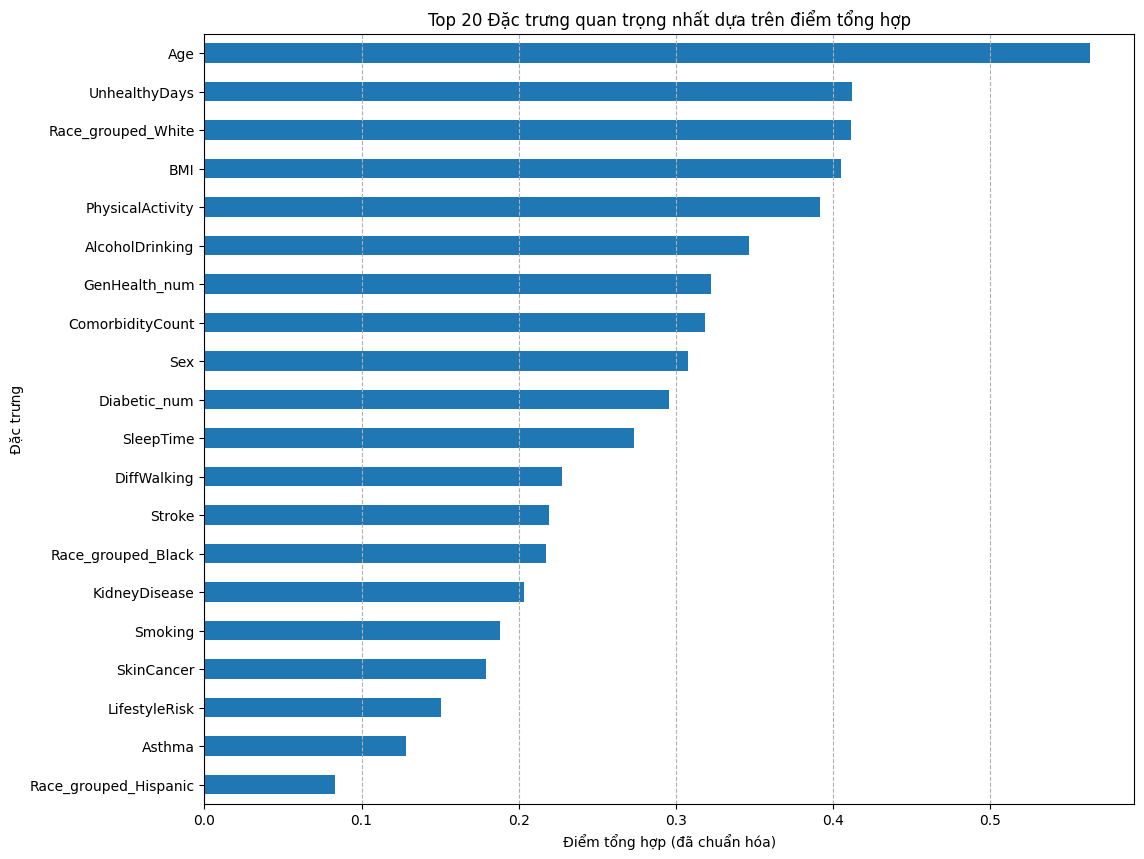

In [ ]:
plt.figure(figsize=(12, 10))
top_features['Combined_Score'].head(20).sort_values(ascending=True).plot(kind='barh')
plt.title('Top 20 Đặc trưng quan trọng nhất dựa trên điểm tổng hợp')
plt.xlabel('Điểm tổng hợp (đã chuẩn hóa)')
plt.ylabel('Đặc trưng')
plt.grid(axis='x', linestyle='--')
plt.show()

In [ ]:
# Top 15 features
for feature in top_features.index[:15]:
    print(f"- {feature}")

NameError: name 'top_features' is not defined

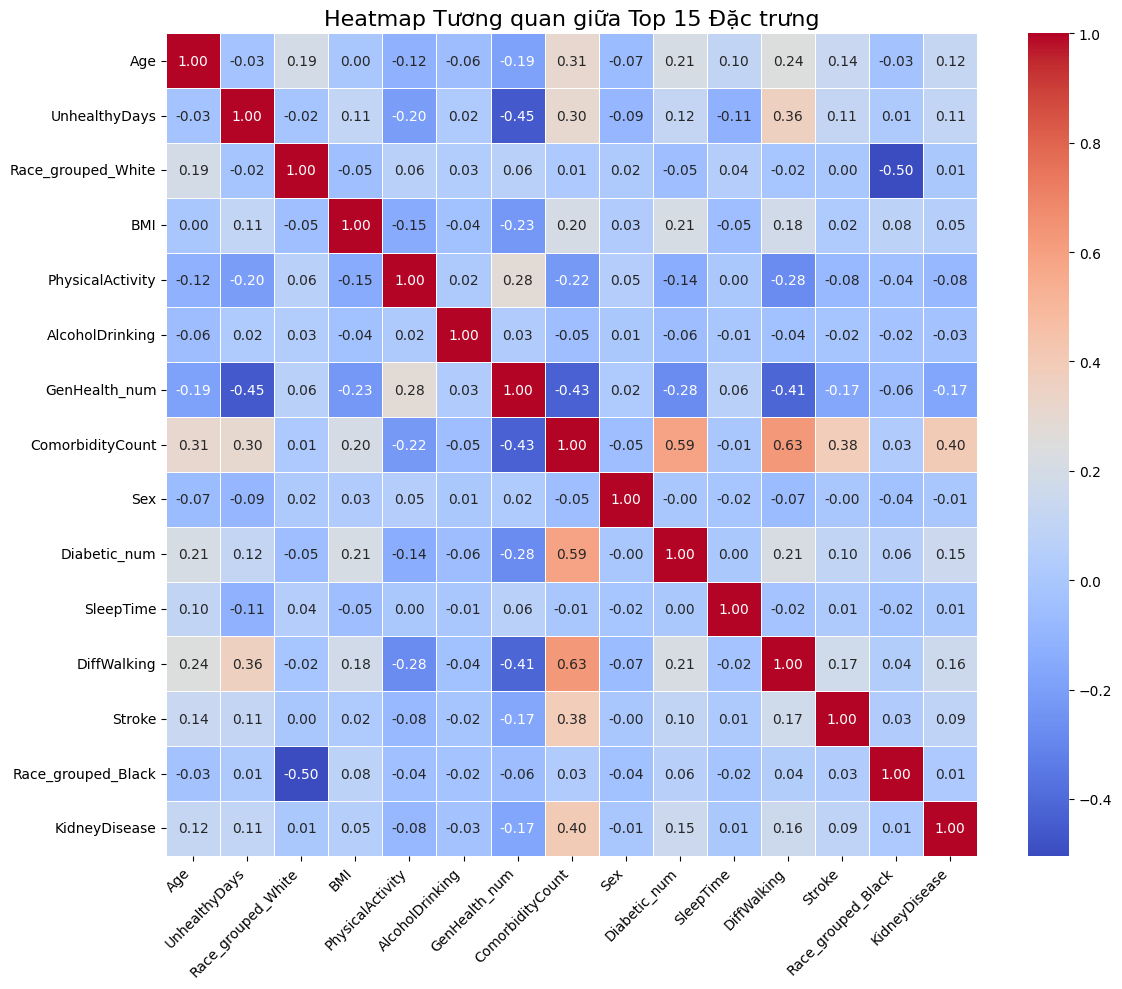

In [ ]:
# Kiểm tra độ tương quan giữa các feature (abs() > 0.8 nên bỏ)
top_15_features = top_features.head(15).index
X_train_top15 = X_train_scaled_df[top_15_features]

corr_matrix = X_train_top15.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidths=.5)
plt.title('Heatmap Tương quan giữa Top 15 Đặc trưng', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## IV. VIF Check

In [ ]:
# VIF < 5: tương quan thấp. 5 <= VIF <= 10: tương quan vừa phải. VIF > 10: tương quan cao
top_20_features = top_features.head(20).index

X_train_top20 = X_train_scaled_df[top_20_features]

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_top20.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_top20.values, i) for i in range(len(X_train_top20.columns))]

display(vif_data.sort_values(by='VIF', ascending=False))

feature        VIF
7        ComorbidityCount  56.243949
11            DiffWalking  10.913937
18                 Asthma  10.846875
9            Diabetic_num  10.657663
2      Race_grouped_White   9.519436
16             SkinCancer   8.212249
15                Smoking   8.123255
17          LifestyleRisk   6.361665
4        PhysicalActivity   4.782008
12                 Stroke   3.821565
14          KidneyDisease   3.774004
5         AlcoholDrinking   2.147558
8                     Sex   1.951071
19  Race_grouped_Hispanic   1.897177
13     Race_grouped_Black   1.761129
6           GenHealth_num   1.578247
1           UnhealthyDays   1.424310
0                     Age   1.329155
3                     BMI   1.120038
10              SleepTime   1.033656

## V. Final Dataset

In [ ]:
final_features_list = [
    'Age',
    'UnhealthyDays',
    'Race_grouped_White',
    'BMI',
    'PhysicalActivity',
    'AlcoholDrinking',
    'GenHealth_num',
    'ComorbidityCount',
    'Sex',
    'SleepTime',
    'Race_grouped_Black',
    'Smoking',
    'SkinCancer',
    'LifestyleRisk',
    'Asthma'
]

In [ ]:
X_train_final = X_train_scaled_df[final_features_list]
X_test_df = pd.DataFrame(X_test_scaled, columns=scaled_feature_names)
X_test_final = X_test_df[final_features_list]

In [ ]:
X_train_final.head()

Age  UnhealthyDays  Race_grouped_White       BMI  PhysicalActivity  \
0 -0.415273       4.131005                 1.0 -0.740760               0.0   
1 -1.544363      -0.491799                 1.0 -0.928238               1.0   
2 -1.262090       3.347479                 0.0  0.781121               0.0   
3  0.713816      -0.570151                 1.0 -0.529650               1.0   
4  0.149272      -0.570151                 1.0 -0.168873               1.0   

   AlcoholDrinking  GenHealth_num  ComorbidityCount  Sex  SleepTime  \
0              0.0      -1.529499          1.631168  0.0  -1.460426   
1              0.0       0.388403         -0.694173  1.0   0.627913   
2              0.0      -1.529499         -0.694173  0.0  -0.068200   
3              0.0       0.388403         -0.694173  0.0   0.627913   
4              0.0       0.388403         -0.694173  0.0  -1.460426   

   Race_grouped_Black  Smoking  SkinCancer  LifestyleRisk  Asthma  
0                 0.0      1.0         0.0       0.698456     1.0  
1                 0.0      0.0         0.0      -0.854386     0.0  
2                 0.0      1.0         0.0       0.698456     0.0  
3                 0.0      1.0         0.0       0.698456     0.0  
4                 0.0      1.0         0.0       0.698456     0.0

# Classification
Attributes (Only binary):
- Heart disease $\color{lime}{\text{(Have one extra column compared to the others)}}$
- Skincancer
- Asthma

Methods used:
- RF
- SVM $\color{lime}{\text{(Since this is computationaly expensive, we cap the number of samples to 10K instead of the full 250K)}}$
- Naive Bayes $\color{lime}{\text{Tradeoff between speed and performance}}$
- MLP

## Heart disease

### RF

Training on 3 parameters set and selecting whatever is the best one

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd


def getSummary(X_test, y_test, baseline = None, fast = None, tuned = None):

    models = {}
    if baseline:
        y_pred_baseline = baseline.predict(X_test)
        models['Baseline'] = y_pred_baseline
    if fast:
        y_pred_fast = fast.predict(X_test)
        models['Fast'] = y_pred_fast
    if tuned:
        y_pred_tuned = tuned.predict(X_test)
        models['Tuned'] = y_pred_tuned

    summary = []

    for name, y_pred in models.items():
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        summary.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1
        })

    return pd.DataFrame(summary)


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))

    # Custom colormap: pink/red (low) → yellow → green (high)
    colors = ["#ffb6c1", "#ff4500", "#ffff66", "#9acd32"]  # pink → red → yellow → green
    cmap = LinearSegmentedColormap.from_list("pink_red_yellow_green", colors)

    im = ax.imshow(cm, cmap=cmap, interpolation="nearest")

    ax.set_title(f"{model_name}", pad=20)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    # Tick marks
    n_classes = cm.shape[0]
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(["Negative", "Positive"])
    ax.set_yticklabels(["Negative", "Positive"])

    # Text annotations with contrasting color
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Use white text for dark cells, black for bright cells
            color = "white" if cm[i, j] > cm.max() / 2 else "black"
            ax.text(j, i, cm[i, j], ha="center", va="center", color=color, fontsize=12)

    # Add colorbar
    # cbar = fig.colorbar(im, ax=ax)
    # cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

def plot_radar_multi(model_metrics, title="Model Comparison"):
    """
    model_metrics format:
    {
        "MLP Baseline": {"Accuracy": 0.916, "Precision": 0.538, "Recall": 0.097, "F1": 0.164},
        "MLP Fast":     {"Accuracy": 0.9162,"Precision": 0.5935,"Recall": 0.0667,"F1": 0.1199},
        "MLP Tuned":    {"Accuracy": 0.9160,"Precision": 0.6036,"Recall": 0.0542,"F1": 0.0995}
    }
    """

    # Extract metric names (assume all models have same metrics)
    metrics = list(next(iter(model_metrics.values())).keys())
    num_metrics = len(metrics)

    # Angles for the radar
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(7, 7))

    # Plot each model
    for model_name, metric_dict in model_metrics.items():
        values = list(metric_dict.values())
        values += values[:1]

        ax.plot(angles, values, label=model_name)
        ax.fill(angles, values, alpha=0.10)

    # Tick labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=11)

    # Remove radial tick labels (cleaner)
    ax.set_yticklabels([])

    # Move title upward to avoid overlap
    plt.title(title, y=1.12, fontsize=14)

    # Legend outside the plot
    plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))

    plt.tight_layout()
    plt.show()

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_pr_curve(y_true, y_scores, model_name="Model"):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve – {model_name}")
    plt.show()


In [ ]:

# Baseline model
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    max_features='log2',
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

# Lightweight model
rf_fast = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# High-performance
rf_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=3,
    max_features='log2',
    min_samples_leaf=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_tuned1 = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=3,
    max_features='log2',
    min_samples_leaf=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)


"""Heart disease"""
rf_baseline.fit(X_train_final, y_train)
# rf_fast.fit(X_train_final, y_train)
# rf_tuned.fit(X_train_final, y_train)

# HeartDiseaseSummary = getSummary(X_test_final, y_test, rf_baseline, rf_fast, rf_tuned)

X_train_SC = X_train_final.drop(columns=['SkinCancer'])
y_train_SC = X_train_final['SkinCancer']
"""Skin cancer"""
# rf_baseline.fit(X_train_SC, y_train_SC)
# rf_fast.fit(X_train_SC, y_train_SC)
rf_tuned.fit(X_train_SC, y_train_SC)

# SkinCancerSummary = getSummary(X_test_final.drop(columns=['SkinCancer']), X_test_final['SkinCancer'], rf_baseline, rf_fast, rf_tuned)

X_train_AS = X_train_final.drop(columns=['Asthma'])
y_train_AS = X_train_final['Asthma']
"""Asthma"""
# rf_baseline.fit(X_train_AS, y_train_AS)
# rf_fast.fit(X_train_AS, y_train_AS)
rf_tuned1.fit(X_train_AS, y_train_AS)

# AsthmaSummary = getSummary(X_test_final.drop(columns=['Asthma']), X_test_final['Asthma'], rf_baseline, rf_fast, rf_tuned)

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=300, n_jobs=-1,
                       random_state=42)

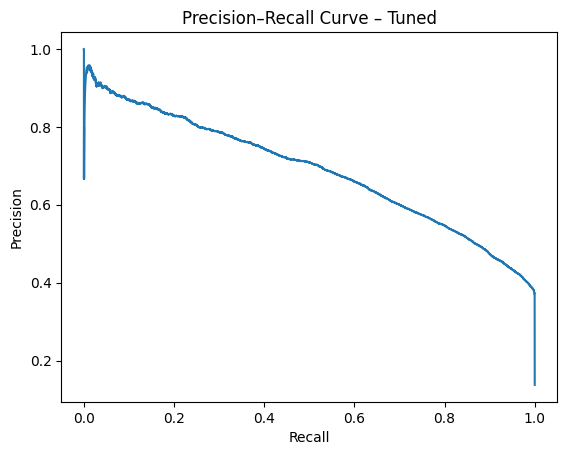

In [ ]:
#Testing on SkinCancer
X1 = X_test_final.drop(columns=['Asthma'])
Y1 = X_test_final['Asthma']

# # Testing on SkinCancer
# X2 = X_test_final.drop(columns=['SkinCancer'])
# Y2 = X_test_final['SkinCancer']

# # Testing on Asthma
# X3 = X_test_final.drop(columns=['Asthma'])
# Y3 = X_test_final['Asthma']

plot_pr_curve(Y1, rf_tuned1.predict_proba(X1)[:, 1], "Tuned")

In [ ]:
print("HeartDiseaseSummary")
display(HeartDiseaseSummary)
# print("SkinCancerSummary")
# display(SkinCancerSummary)
# print("AsthmaSummary")
# display(AsthmaSummary)

HeartDiseaseSummary


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.903657   0.338959  0.132055  0.190063
1      Fast  0.915524   0.665138  0.026484  0.050940
2     Tuned  0.915383   0.545455  0.069041  0.122568

SkinCancerSummary


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.915977   0.560718  0.422316  0.481774
1      Fast  0.917682   0.692308  0.197802  0.307692
2     Tuned  0.923310   0.624384  0.428571  0.508271

AsthmaSummary


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.892994   0.633525  0.526040  0.574801
1      Fast  0.897512   0.775129  0.358654  0.490399
2     Tuned  0.903141   0.702698  0.512281  0.592568

### SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np


param_grid = {
    "C":     [0.1, 1.0, 10.0, 100.0],
    "gamma": [0.001, 0.01, 0.1, 1.0],
    "kernel": ["rbf"]
}


grid = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    scoring="recall",
    cv=3,
    n_jobs=-1,
    verbose=0
)
X_train_final = X_train_final.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train_sample = X_train_final.sample(n=20000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

grid.fit(X_train_sample, y_train_sample)


best_C     = grid.best_params_["C"]
best_gamma = grid.best_params_["gamma"]

print(f"Best parameters → C = {best_C}, gamma = {best_gamma}")
print(f"Best F1    → {grid.best_score_:.4f}")

Best parameters → C = 100.0, gamma = 0.1
Best F1    → 0.1447


In [ ]:
tuned_svm = grid.best_estimator_
HeartDiseaseSummarySVM = getSummary(X_test_final, y_test, None, None, tuned_svm)


In [ ]:
grid.cv_results_

{'mean_fit_time': array([ 4.50495553,  4.66970221,  9.6308132 , 19.86720896,  3.26160049,
         6.76426069,  9.14028605, 28.31866113,  5.30317847, 18.58042828,
        19.56806827, 33.46428974, 31.48292136, 36.32855177, 31.33900777,
        28.0964454 ]),
 'std_fit_time': array([0.45610908, 0.52984834, 1.7390456 , 1.57367376, 0.0280945 ,
        0.645051  , 0.59205703, 3.87309707, 0.50416459, 0.23636003,
        4.99027389, 2.53102547, 3.16879062, 3.58579707, 2.4510705 ,
        3.91156036]),
 'mean_score_time': array([3.21673592, 5.15767686, 4.72054688, 9.16727718, 5.13422314,
        3.83751059, 4.61029212, 6.21109064, 2.98967576, 2.74616901,
        3.52515912, 5.02064983, 2.91550223, 2.58314586, 2.73175542,
        3.42998306]),
 'std_score_time': array([0.4979018 , 2.19784067, 1.59580231, 3.02532479, 0.90992158,
        1.87608521, 1.42480315, 0.70061015, 0.74018404, 0.77442749,
        1.40888244, 0.18952425, 0.11940039, 0.65976807, 0.41681768,
        0.80601755]),
 'param_C'

In [ ]:
HeartDiseaseSummarySVM

Model  Accuracy  Precision    Recall  F1-Score
0  Tuned  0.902047   0.331485  0.141918  0.198747

In [ ]:
from sklearn.svm import SVC

# Baseline
svm_baseline = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)

# Lightweight
svm_fast = SVC(
    kernel='linear',
    random_state=42
)

# High-performance
svm_tuned = SVC(
    kernel='rbf',
    C=100,
    gamma=0.1,
    random_state=42
)

svm_tuned1 = SVC(
    kernel='rbf',
    C=100,
    gamma=0.1,
    random_state=42
)

"""Limit samples to 100K"""
X_train_final = X_train_final.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train_sample = X_train_final.sample(n=50000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

"""Heart disease"""
# svm_baseline.fit(X_train_sample, y_train_sample)
# svm_fast.fit(X_train_sample, y_train_sample)
svm_tuned.fit(X_train_sample, y_train_sample)

HeartDiseaseSummarySVM = getSummary(X_test_final, y_test, None, None, svm_tuned)


"""Skin cancer"""
X_train_SC = X_train_final.drop(columns=['SkinCancer'])
y_train_SC = X_train_final['SkinCancer']

# Randomly sample 10,000 rows while keeping X and y aligned
X_train_SC = X_train_SC.sample(n=50000, random_state=42)
y_train_SC = y_train_SC.loc[X_train_SC.index]


# svm_baseline.fit(X_train_SC, y_train_SC)
# svm_fast.fit(X_train_SC, y_train_SC)
svm_tuned1.fit(X_train_SC, y_train_SC)

SkinCancerSummarySVM = getSummary(X_test_final.drop(columns=['SkinCancer']), X_test_final['SkinCancer'], None, None, svm_tuned1)


"""Asthma"""
X_train_AS = X_train_final.drop(columns=['Asthma'])
y_train_AS = X_train_final['Asthma']

X_train_AS = X_train_AS.sample(n=50000, random_state=42)
y_train_AS = y_train_AS.loc[X_train_AS.index]


svm_baseline.fit(X_train_AS, y_train_AS)
# svm_fast.fit(X_train_AS, y_train_AS)
# svm_tuned.fit(X_train_AS, y_train_AS)

AsthmaSummarySVM = getSummary(X_test_final.drop(columns=['Asthma']), X_test_final['Asthma'], svm_baseline, None, None)

In [ ]:
print("HeartDiseaseSummarySVM")
display(HeartDiseaseSummarySVM)
print("SkinCancerSummarySVM")
display(SkinCancerSummarySVM)
print("AsthmaSummarySVM")
display(AsthmaSummarySVM)

HeartDiseaseSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Tuned  0.906925   0.352651  0.104475  0.161195

SkinCancerSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Tuned  0.918245   0.574339  0.448014  0.503372

AsthmaSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.902672   0.724917  0.470776  0.570838

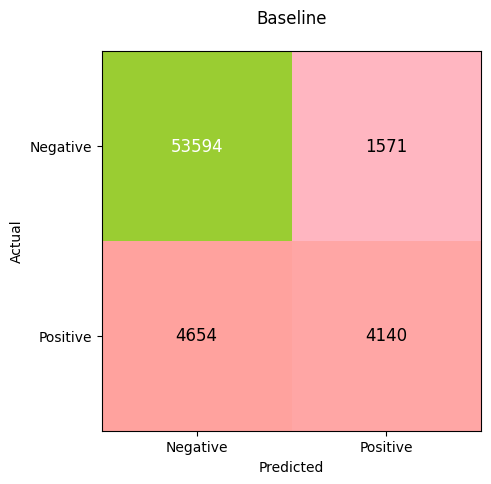

In [ ]:
# X1 = X_test_final
# Y1 = y_test

# # Testing on SkinCancer
# X2 = X_test_final.drop(columns=['SkinCancer'])
# Y2 = X_test_final['SkinCancer']

# # Testing on Asthma
X3 = X_test_final.drop(columns=['Asthma'])
Y3 = X_test_final['Asthma']

plot_confusion_matrix(Y3, svm_baseline.predict(X3), "Baseline")

In [ ]:
# Result -- do not touch

print("HeartDiseaseSummarySVM")
display(HeartDiseaseSummarySVM)
print("SkinCancerSummarySVM")
display(SkinCancerSummarySVM)
print("AsthmaSummarySVM")
display(AsthmaSummarySVM)

HeartDiseaseSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.915461      0.636  0.029041  0.055546
1      Fast  0.914398      0.000  0.000000  0.000000
2     Tuned  0.914492      0.875  0.001279  0.002553

SkinCancerSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.923216   0.661104  0.348267  0.456206
1      Fast  0.915540   0.636364  0.202367  0.307081
2     Tuned  0.922419   0.669996  0.317498  0.430833

AsthmaSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.902672   0.724917  0.470776  0.570838
1      Fast  0.887725   0.679182  0.347623  0.459872
2     Tuned  0.901109   0.740596  0.432113  0.545781

In [ ]:
### 150k samples result

print("HeartDiseaseSummarySVM")
display(HeartDiseaseSummarySVM)
print("SkinCancerSummarySVM")
display(SkinCancerSummarySVM)
print("AsthmaSummarySVM")
display(AsthmaSummarySVM)

HeartDiseaseSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.915461      0.636  0.029041  0.055546
1      Fast  0.914398      0.000  0.000000  0.000000
2     Tuned  0.914492      0.875  0.001279  0.002553

SkinCancerSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.923216   0.661104  0.348267  0.456206
1      Fast  0.915540   0.636364  0.202367  0.307081
2     Tuned  0.922419   0.669996  0.317498  0.430833

AsthmaSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.902672   0.724917  0.470776  0.570838
1      Fast  0.887725   0.679182  0.347623  0.459872
2     Tuned  0.901109   0.740596  0.432113  0.545781

In [ ]:
### 50k samples result

print("HeartDiseaseSummarySVM")
display(HeartDiseaseSummarySVM)
print("SkinCancerSummarySVM")
display(SkinCancerSummarySVM)
print("AsthmaSummarySVM")
display(AsthmaSummarySVM)

HeartDiseaseSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.915461      0.636  0.029041  0.055546
1      Fast  0.914398      0.000  0.000000  0.000000
2     Tuned  0.914492      0.875  0.001279  0.002553

SkinCancerSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.923216   0.661104  0.348267  0.456206
1      Fast  0.915540   0.636364  0.202367  0.307081
2     Tuned  0.922419   0.669996  0.317498  0.430833

AsthmaSummarySVM


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.902672   0.724917  0.470776  0.570838
1      Fast  0.887725   0.679182  0.347623  0.459872
2     Tuned  0.901109   0.740596  0.432113  0.545781

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Baseline
nb_baseline = GaussianNB(var_smoothing=1e-9)

# lightweight
nb_fast = GaussianNB(var_smoothing=1e-8)

# high-performance
nb_tuned = GaussianNB(var_smoothing=1e-6)


"""Heart disease"""
# nb_baseline.fit(X_train_final, y_train)
# nb_fast.fit(X_train_final, y_train)
# nb_tuned.fit(X_train_final, y_train)

# HeartDiseaseSummaryNB = getSummary(X_test_final, y_test, nb_baseline, nb_fast, nb_tuned)

# """Skin cancer"""
# X_train_SC = X_train_final.drop(columns=['SkinCancer'])
# y_train_SC = X_train_final['SkinCancer']

# nb_baseline.fit(X_train_SC, y_train_SC)
# nb_fast.fit(X_train_SC, y_train_SC)
# nb_tuned.fit(X_train_SC, y_train_SC)

# SkinCancerSummaryNB = getSummary(X_test_final.drop(columns=['SkinCancer']), X_test_final['SkinCancer'], nb_baseline, nb_fast, nb_tuned)

# """Asthma"""
X_train_AS = X_train_final.drop(columns=['Asthma'])
y_train_AS = X_train_final['Asthma']

nb_baseline.fit(X_train_AS, y_train_AS)
nb_fast.fit(X_train_AS, y_train_AS)
nb_tuned.fit(X_train_AS, y_train_AS)

AsthmaSummaryNB = getSummary(X_test_final.drop(columns=['Asthma']), X_test_final['Asthma'], nb_baseline, nb_fast, nb_tuned)

In [ ]:
print("HeartDiseaseSummaryNB")
display(HeartDiseaseSummaryNB)
print("SkinCancerSummaryNB")
display(SkinCancerSummaryNB)
print("AsthmaSummaryNB")
display(AsthmaSummaryNB)

HeartDiseaseSummaryNB


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.848872   0.267193  0.439269  0.332274
1      Fast  0.848872   0.267193  0.439269  0.332274
2     Tuned  0.848872   0.267193  0.439269  0.332274

SkinCancerSummaryNB


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.830219   0.332293  0.828064  0.474268
1      Fast  0.830219   0.332293  0.828064  0.474268
2     Tuned  0.830235   0.332316  0.828064  0.474291

AsthmaSummaryNB


Model  Accuracy  Precision    Recall  F1-Score
0  Baseline  0.830751   0.376234  0.351035  0.363198
1      Fast  0.830751   0.376234  0.351035  0.363198
2     Tuned  0.830751   0.376234  0.351035  0.363198

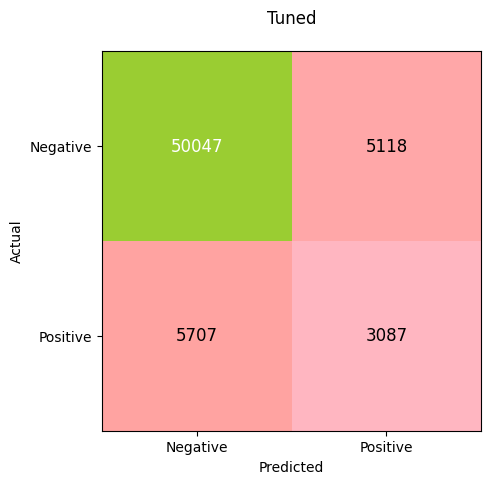

In [ ]:
# X1 = X_test_final
# Y1 = y_test

# # Testing on SkinCancer
# X2 = X_test_final.drop(columns=['SkinCancer'])
# Y2 = X_test_final['SkinCancer']

# # Testing on Asthma
X3 = X_test_final.drop(columns=['Asthma'])
Y3 = X_test_final['Asthma']

plot_confusion_matrix(Y3, nb_tuned.predict(X3), "Tuned")

### MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64, 32], dropout=0.0):
        super(MLP, self).__init__()
        layers = []
        in_features = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())  ### by default the activation function is ReLu
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_features = h
        layers.append(nn.Linear(in_features, 1))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


def to_tensor(X, y, device):
    X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1).to(device)
    return X_tensor, y_tensor

def train_mlp(model, X_train, y_train, lr=1e-3, epochs=10, batch_size=256, device="cpu", task_name="Training"):
    model.to(device)
    dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        # Add title to tqdm
        for X_batch, y_batch in tqdm(loader, desc=f"{task_name} - Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataset):.4f}")

    return model

def evaluate_mlp(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        preds = (preds.cpu().numpy() > 0.5).astype(int)
        y_true = y_test.cpu().numpy().astype(int)
    return {
        "Accuracy": accuracy_score(y_true, preds),
        "Precision": precision_score(y_true, preds),
        "Recall": recall_score(y_true, preds),
        "F1": f1_score(y_true, preds)
    }

def predict(model, X_test, threshold=0.5):
    model.eval()
    with torch.no_grad():
        raw_probs = model(X_test)
        if not threshold: return raw_probs
        # Apply threshold to convert probabilities to binary predictions
        preds = (raw_probs > threshold).float()
    return preds

Using device: cpu


In [ ]:
input_dim = X_train_final.shape[1]

X_train_t, y_train_t = to_tensor(X_train_final, y_train, device)
X_test_t, y_test_t = to_tensor(X_test_final, y_test, device)

"""15 features"""
mlp_baseline = MLP(input_dim, hidden_layers=[64, 32], dropout=0.0)
# mlp_fast = MLP(input_dim, hidden_layers=[32], dropout=0.0)
# mlp_tuned = MLP(input_dim, hidden_layers=[128, 64, 32], dropout=0.2)

mlp_baseline = train_mlp(mlp_baseline, X_train_t, y_train_t, lr=1e-3, epochs=10, device=device, task_name="baseline")
# mlp_fast = train_mlp(mlp_fast, X_train_t, y_train_t, lr=1e-3, epochs=6, device=device, task_name="fast")
# mlp_tuned = train_mlp(mlp_tuned, X_train_t, y_train_t, lr=5e-4, epochs=15, device=device, task_name="tuned")


HeartDiseaseSummaryMLP = pd.DataFrame([
    {"Model": "Baseline", **evaluate_mlp(mlp_baseline, X_test_t, y_test_t)},
    # {"Model": "Fast", **evaluate_mlp(mlp_fast, X_test_t, y_test_t)},
    # {"Model": "Tuned", **evaluate_mlp(mlp_tuned, X_test_t, y_test_t)}
])

### Different number of features and we also have to declare new models for different target attributes

X_train_SC = X_train_final.drop(columns=['SkinCancer'])
y_train_SC = X_train_final['SkinCancer']
X_test_SC = X_test_final.drop(columns=['SkinCancer'])
y_test_SC = X_test_final['SkinCancer']


input_dim = X_train_SC.shape[1]

# mlp_baseline = MLP(input_dim, hidden_layers=[64, 32], dropout=0.0)
mlp_fast = MLP(input_dim, hidden_layers=[32], dropout=0.0)
# mlp_tuned = MLP(input_dim, hidden_layers=[128, 64, 32], dropout=0.2)


X_train_t, y_train_t = to_tensor(X_train_SC, y_train_SC, device)
X_test_t, y_test_t = to_tensor(X_test_SC, y_test_SC, device)

# mlp_baseline = train_mlp(mlp_baseline, X_train_t, y_train_t, lr=1e-3, epochs=10, device=device, task_name="baseline")
mlp_fast = train_mlp(mlp_fast, X_train_t, y_train_t, lr=1e-3, epochs=6, device=device, task_name="fast")
# mlp_tuned = train_mlp(mlp_tuned, X_train_t, y_train_t, lr=5e-4, epochs=15, device=device, task_name="tuned")


SkinCancerSummaryMLP = pd.DataFrame([
    # {"Model": "Baseline", **evaluate_mlp(mlp_baseline, X_test_t, y_test_t)},
    {"Model": "Fast", **evaluate_mlp(mlp_fast, X_test_t, y_test_t)},
    # {"Model": "Tuned", **evaluate_mlp(mlp_tuned, X_test_t, y_test_t)}
])


X_train_AS = X_train_final.drop(columns=['Asthma'])
y_train_AS = X_train_final['Asthma']
X_test_AS = X_test_final.drop(columns=['Asthma'])
y_test_AS = X_test_final['Asthma']

input_dim = X_train_AS.shape[1]

mlp_baseline1 = MLP(input_dim, hidden_layers=[64, 32], dropout=0.0)
# mlp_fast = MLP(input_dim, hidden_layers=[32], dropout=0.0)
# mlp_tuned = MLP(input_dim, hidden_layers=[128, 64, 32], dropout=0.2)

X_train_t, y_train_t = to_tensor(X_train_AS, y_train_AS, device)
X_test_t, y_test_t = to_tensor(X_test_AS, y_test_AS, device)

mlp_baseline1 = train_mlp(mlp_baseline1, X_train_t, y_train_t, lr=1e-3, epochs=10, device=device, task_name="baseline")
# mlp_fast = train_mlp(mlp_fast, X_train_t, y_train_t, lr=1e-3, epochs=6, device=device, task_name="fast")
# mlp_tuned = train_mlp(mlp_tuned, X_train_t, y_train_t, lr=5e-4, epochs=15, device=device, task_name="tuned")


AsthmaSummaryMLP = pd.DataFrame([
    {"Model": "Baseline", **evaluate_mlp(mlp_baseline1, X_test_t, y_test_t)},
    # {"Model": "Fast", **evaluate_mlp(mlp_fast, X_test_t, y_test_t)},
    # {"Model": "Tuned", **evaluate_mlp(mlp_tuned, X_test_t, y_test_t)}
])

baseline - Epoch 1/10: 100%|██████████| 1000/1000 [00:10<00:00, 96.56it/s]


Epoch [1/10], Loss: 0.2427


baseline - Epoch 2/10: 100%|██████████| 1000/1000 [00:06<00:00, 146.77it/s]


Epoch [2/10], Loss: 0.2275


baseline - Epoch 3/10: 100%|██████████| 1000/1000 [00:05<00:00, 194.03it/s]


Epoch [3/10], Loss: 0.2266


baseline - Epoch 4/10: 100%|██████████| 1000/1000 [00:04<00:00, 227.40it/s]


Epoch [4/10], Loss: 0.2263


baseline - Epoch 5/10: 100%|██████████| 1000/1000 [00:04<00:00, 218.97it/s]


Epoch [5/10], Loss: 0.2259


baseline - Epoch 6/10: 100%|██████████| 1000/1000 [00:05<00:00, 183.36it/s]


Epoch [6/10], Loss: 0.2257


baseline - Epoch 7/10: 100%|██████████| 1000/1000 [00:04<00:00, 242.53it/s]


Epoch [7/10], Loss: 0.2256


baseline - Epoch 8/10: 100%|██████████| 1000/1000 [00:05<00:00, 193.09it/s]


Epoch [8/10], Loss: 0.2255


baseline - Epoch 9/10: 100%|██████████| 1000/1000 [00:04<00:00, 212.66it/s]


Epoch [9/10], Loss: 0.2255


baseline - Epoch 10/10: 100%|██████████| 1000/1000 [00:04<00:00, 239.72it/s]


Epoch [10/10], Loss: 0.2253


fast - Epoch 1/6: 100%|██████████| 1000/1000 [00:04<00:00, 209.76it/s]


Epoch [1/6], Loss: 0.2284


fast - Epoch 2/6: 100%|██████████| 1000/1000 [00:04<00:00, 244.30it/s]


Epoch [2/6], Loss: 0.1594


fast - Epoch 3/6: 100%|██████████| 1000/1000 [00:03<00:00, 262.29it/s]


Epoch [3/6], Loss: 0.1554


fast - Epoch 4/6: 100%|██████████| 1000/1000 [00:03<00:00, 266.82it/s]


Epoch [4/6], Loss: 0.1541


fast - Epoch 5/6: 100%|██████████| 1000/1000 [00:05<00:00, 198.98it/s]


Epoch [5/6], Loss: 0.1534


fast - Epoch 6/6: 100%|██████████| 1000/1000 [00:03<00:00, 272.15it/s]


Epoch [6/6], Loss: 0.1530


baseline - Epoch 1/10: 100%|██████████| 1000/1000 [00:04<00:00, 220.29it/s]


Epoch [1/10], Loss: 0.2147


baseline - Epoch 2/10: 100%|██████████| 1000/1000 [00:05<00:00, 181.20it/s]


Epoch [2/10], Loss: 0.1906


baseline - Epoch 3/10: 100%|██████████| 1000/1000 [00:04<00:00, 220.55it/s]


Epoch [3/10], Loss: 0.1898


baseline - Epoch 4/10: 100%|██████████| 1000/1000 [00:04<00:00, 234.29it/s]


Epoch [4/10], Loss: 0.1895


baseline - Epoch 5/10: 100%|██████████| 1000/1000 [00:05<00:00, 179.53it/s]


Epoch [5/10], Loss: 0.1893


baseline - Epoch 6/10: 100%|██████████| 1000/1000 [00:04<00:00, 246.94it/s]


Epoch [6/10], Loss: 0.1891


baseline - Epoch 7/10: 100%|██████████| 1000/1000 [00:04<00:00, 222.95it/s]


Epoch [7/10], Loss: 0.1890


baseline - Epoch 8/10: 100%|██████████| 1000/1000 [00:05<00:00, 182.42it/s]


Epoch [8/10], Loss: 0.1888


baseline - Epoch 9/10: 100%|██████████| 1000/1000 [00:04<00:00, 236.36it/s]


Epoch [9/10], Loss: 0.1887


baseline - Epoch 10/10: 100%|██████████| 1000/1000 [00:04<00:00, 202.73it/s]


Epoch [10/10], Loss: 0.1886


Simulated Confusion Matrix:
 [[52884  2283]
 [ 3819  4973]]


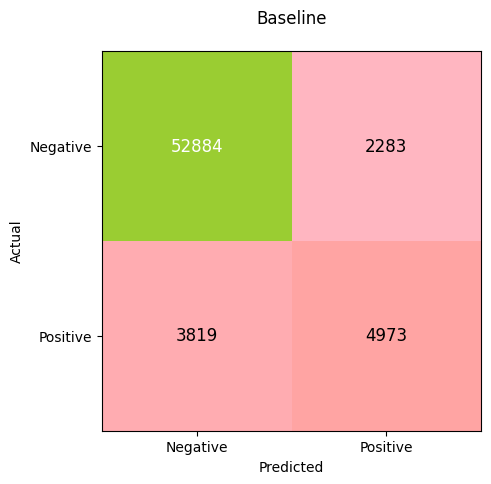

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Given metrics

acc = 0.904564
pre = 0.685313
rec = 0.565613
N = 63959

# Correct TP formula using acc
TP = int(N * (1 - acc) / (1/pre + 1/rec - 2))
FN = int(TP * (1/rec - 1))
FP = int(TP * (1/pre - 1))
TN = N - TP - FP - FN
cm = np.array([[TN, FP],
               [FN, TP]])

print("Simulated Confusion Matrix:\n", cm)

# Plotting
fig, ax = plt.subplots(figsize=(5, 5))

# Custom colormap: pink/red → yellow → green
colors = ["#ffb6c1", "#ff4500", "#ffff66", "#9acd32"]
cmap = LinearSegmentedColormap.from_list("pink_red_yellow_green", colors)

im = ax.imshow(cm, cmap=cmap, interpolation="nearest")
ax.set_title("Baseline", pad=20)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Tick marks
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])

# Annotate cells
for i in range(2):
    for j in range(2):
        color = "white" if cm[i, j] > cm.max()/2 else "black"
        ax.text(j, i, cm[i, j], ha="center", va="center", color=color, fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
print("HeartDiseaseSummaryMLP")
display(HeartDiseaseSummaryMLP)
print("SkinCancerSummaryMLP")
display(SkinCancerSummaryMLP)
print("AsthmaSummaryMLP")
display(AsthmaSummaryMLP)

HeartDiseaseSummaryMLP


Model  Accuracy  Precision    Recall        F1
0  Baseline  0.915915   0.589319  0.058447  0.106348

SkinCancerSummaryMLP


Model  Accuracy  Precision    Recall        F1
0  Fast   0.92553    0.62446  0.488588  0.548231

AsthmaSummaryMLP


Model  Accuracy  Precision    Recall        F1
0  Baseline  0.904705   0.681555  0.576075  0.624391

In [ ]:
print("HeartDiseaseSummaryMLP")
display(HeartDiseaseSummaryMLP)
print("SkinCancerSummaryMLP")
display(SkinCancerSummaryMLP)
print("AsthmaSummaryMLP")
display(AsthmaSummaryMLP)

HeartDiseaseSummaryMLP


Model  Accuracy  Precision    Recall        F1
0  Baseline  0.915555   0.537602  0.096621  0.163802
1      Fast  0.916196   0.593496  0.066667  0.119869
2     Tuned  0.915993   0.603659  0.054247  0.099548

SkinCancerSummaryMLP


Model  Accuracy  Precision    Recall        F1
0  Baseline  0.925609   0.629505  0.475402  0.541707
1      Fast  0.924545   0.603066  0.538631  0.569030
2     Tuned  0.925468   0.630395  0.469146  0.537947

AsthmaSummaryMLP


Model  Accuracy  Precision    Recall        F1
0  Baseline  0.904564   0.685313  0.565613  0.619736
1      Fast  0.904548   0.690790  0.553559  0.614608
2     Tuned  0.905017   0.706957  0.528087  0.604569

#Clustering

##KMeans

**Outlier**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- 1. TÁCH ĐẶC TRƯNG ---
print("\n--- Bắt đầu Quy trình Xử lý Dữ liệu ---")

quantitative_features = [
    'Age', 'UnhealthyDays', 'BMI', 'GenHealth_num',
    'ComorbidityCount', 'SleepTime', 'LifestyleRisk'
]

binary_features = [
    'Race_grouped_White', 'PhysicalActivity', 'AlcoholDrinking',
    'Sex', 'Race_grouped_Black', 'Smoking', 'SkinCancer', 'Asthma'
]

X_quant = X_train_final[quantitative_features].copy()
X_binary = X_train_final[binary_features].copy()

# --- 2. XỬ LÝ OUTLIER BẰNG CAPPING ---

def cap_outliers_iqr(df, threshold=1.5):
    """Giới hạn (capping) các giá trị ngoại lai về ngưỡng IQR."""
    df_capped = df.copy()
    for column in df.columns:
        Q1 = df_capped[column].quantile(0.25)
        Q3 = df_capped[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)

        df_capped[column] = np.where(df_capped[column] > upper_bound, upper_bound, df_capped[column])
        df_capped[column] = np.where(df_capped[column] < lower_bound, lower_bound, df_capped[column])

    print(f"Đã hoàn thành Capping cho {len(df.columns)} đặc trưng định lượng.")
    return df_capped

# Áp dụng Capping
X_quant_capped = cap_outliers_iqr(X_quant)

# --- 3. KẾT HỢP DỮ LIỆU ---

X_train_clean = pd.concat([X_quant_capped, X_binary], axis=1)

print(f"DataFrame cuối cùng để phân cụm (X_train_clean) có kích thước: {X_train_clean.shape}")




--- Bắt đầu Quy trình Xử lý Dữ liệu ---
Đã hoàn thành Capping cho 7 đặc trưng định lượng.
DataFrame cuối cùng để phân cụm (X_train_clean) có kích thước: (255836, 15)


In [ ]:
print(X_train_clean.head)

<bound method NDFrame.head of              Age  UnhealthyDays       BMI  GenHealth_num  ComorbidityCount  \
0      -0.415273       0.996901 -0.740760      -1.529499          1.631168   
1      -1.544363      -0.491799 -0.928238       0.388403         -0.694173   
2      -1.262090       0.996901  0.781121      -1.529499         -0.694173   
3       0.713816      -0.570151 -0.529650       0.388403         -0.694173   
4       0.149272      -0.570151 -0.168873       0.388403         -0.694173   
...          ...            ...       ...            ...               ...   
255831  0.713816      -0.570151  0.391985       1.347354          1.631168   
255832 -1.262090       0.056670 -1.285864      -0.570548          0.468498   
255833 -0.979818      -0.570151 -1.485946       1.347354         -0.694173   
255834  1.447725      -0.570151 -0.520198      -0.570548          0.468498   
255835  0.149272      -0.570151  0.666113      -0.570548         -0.694173   

        SleepTime  LifestyleRisk 

**Select Feature**

In [ ]:
# -----------------------------------------------------
# --- CHỌN LỌC ĐẶC TRƯNG / GIẢM CHIỀU DỮ LIỆU ---
# -----------------------------------------------------

features_to_drop_manually = [
    'AlcoholDrinking',
    'Race_grouped_Black',
    'SkinCancer',
    'Asthma',
    'SleepTime',
    'Sex',
    'Race_grouped_White',
    'PhysicalActivity',
    'Smoking'
]

data_for_clustering = X_train_clean.drop(columns=features_to_drop_manually)

In [ ]:
print(data_for_clustering.head)

<bound method NDFrame.head of              Age  UnhealthyDays       BMI  GenHealth_num  ComorbidityCount  \
0      -0.415273       0.996901 -0.740760      -1.529499          1.631168   
1      -1.544363      -0.491799 -0.928238       0.388403         -0.694173   
2      -1.262090       0.996901  0.781121      -1.529499         -0.694173   
3       0.713816      -0.570151 -0.529650       0.388403         -0.694173   
4       0.149272      -0.570151 -0.168873       0.388403         -0.694173   
...          ...            ...       ...            ...               ...   
255831  0.713816      -0.570151  0.391985       1.347354          1.631168   
255832 -1.262090       0.056670 -1.285864      -0.570548          0.468498   
255833 -0.979818      -0.570151 -1.485946       1.347354         -0.694173   
255834  1.447725      -0.570151 -0.520198      -0.570548          0.468498   
255835  0.149272      -0.570151  0.666113      -0.570548         -0.694173   

        LifestyleRisk  
0        

***Elbow chọn k***


--- Bắt đầu Tính toán Phương pháp Elbow ---
Đã tính WCSS cho K=1
Đã tính WCSS cho K=2
Đã tính WCSS cho K=3
Đã tính WCSS cho K=4
Đã tính WCSS cho K=5
Đã tính WCSS cho K=6
Đã tính WCSS cho K=7
Đã tính WCSS cho K=8
Đã tính WCSS cho K=9
Đã tính WCSS cho K=10


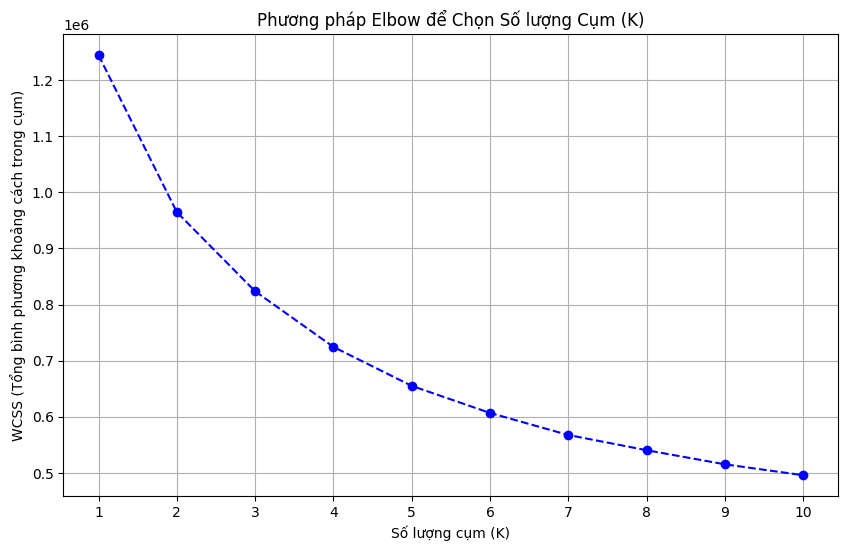

In [ ]:
# --- 4. PHƯƠNG PHÁP ELBOW ĐỂ CHỌN K ---

print("\n--- Bắt đầu Tính toán Phương pháp Elbow ---")

data = data_for_clustering.copy()

wcss = []

max_k = 11
for i in range(1, max_k):
    # K-Means chạy 10 lần với các khởi tạo tâm cụm khác nhau
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    print(f"Đã tính WCSS cho K={i}")

# --- 5. VẼ BIỂU ĐỒ ELBOW ---

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k), wcss, marker='o', linestyle='--', color='blue')
plt.title('Phương pháp Elbow để Chọn Số lượng Cụm (K)')
plt.xlabel('Số lượng cụm (K)')
plt.ylabel('WCSS (Tổng bình phương khoảng cách trong cụm)')
plt.xticks(np.arange(1, max_k, 1))
plt.grid(True)
plt.show()

In [ ]:
print(wcss)

[1244399.6054873827, 964621.7070077205, 823621.3749637667, 724432.5628984156, 655066.9664126519, 606760.8477791208, 567477.22647941, 540364.4448671071, 515217.13618321106, 495768.2858903138]


**Tiến hành chọn k = 3 hoặc k = 4 cho KMeans**

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

def run_kmeans_clustering(data, k):
    """
    Thực hiện K-Means Clustering và gán nhãn cụm cho dữ liệu.
    """

    # 1. Khởi tạo mô hình K-Means
    print(f"Bắt đầu huấn luyện K-Means với K = {k}...")
    kmeans_model = KMeans(
        n_clusters=k,
        init='k-means++',
        random_state=42,
        n_init=10
    )

    # 2. Huấn luyện và dự đoán nhãn cụm
    cluster_labels = kmeans_model.fit_predict(data)

    # 3. Gán nhãn cụm vào DataFrame
    df_clustered = data.copy()
    df_clustered['Cluster'] = cluster_labels

    print(f"Hoàn thành. Đã phân cụm thành {k} nhóm.")
    print(f"Kích thước của các cụm:\n{df_clustered['Cluster'].value_counts()}")

    return df_clustered, kmeans_model


df_clustered_k4, kmeans_k4 = run_kmeans_clustering(data_for_clustering, k=3)


Bắt đầu huấn luyện K-Means với K = 3...
Hoàn thành. Đã phân cụm thành 3 nhóm.
Kích thước của các cụm:
Cluster
1    108973
0     82108
2     64755
Name: count, dtype: int64


**Đánh giá định tính:**

**So sánh đặc trưng theo heatmap:**

--- Hồ sơ Cụm (Cluster Profile) ---
              Age  UnhealthyDays       BMI  GenHealth_num  ComorbidityCount  \
Cluster                                                                       
0       -0.098042      -0.227722 -0.171393       0.243009         -0.412101   
1       -0.295019      -0.316606 -0.176171       0.436798         -0.427466   
2        0.620788       0.164554  0.407443      -0.976186          1.100915   

         LifestyleRisk  
Cluster                 
0             0.975803  
1            -0.854386  
2             0.189043  


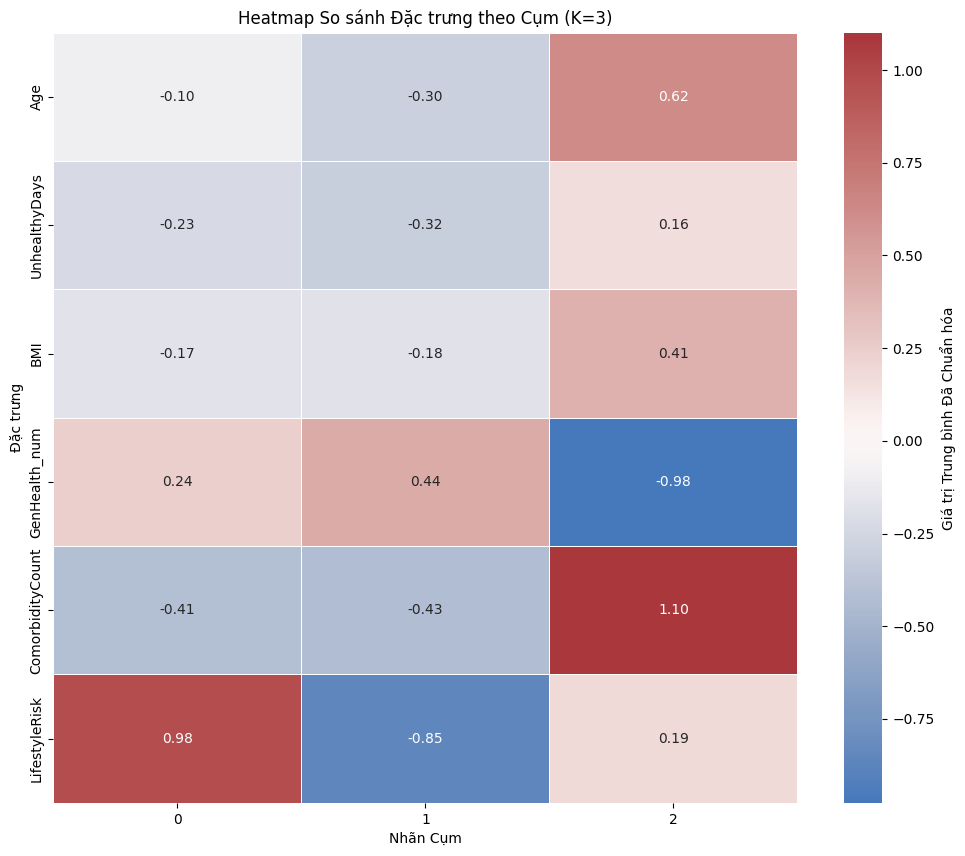

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Tạo Hồ sơ Cụm (Cluster Profile) ---
print("--- Hồ sơ Cụm (Cluster Profile) ---")
cluster_profile_k4 = df_clustered_k4.groupby('Cluster').mean()
print(cluster_profile_k4)

# --- 2. Trực quan hóa Hồ sơ Cụm ---

profile_transposed = cluster_profile_k4.T

# Tạo Heatmap để so sánh trực quan
plt.figure(figsize=(12, 10))
sns.heatmap(
    profile_transposed,
    cmap='vlag',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Giá trị Trung bình Đã Chuẩn hóa'}
)
plt.title(f'Heatmap So sánh Đặc trưng theo Cụm (K=3)')
plt.ylabel('Đặc trưng')
plt.xlabel('Nhãn Cụm')
plt.show()

**Bar plot:**

/tmp/ipython-input-3032693267.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3032693267.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3032693267.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3032693267.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3032693267.py:12: FutureWarning: 

Passin

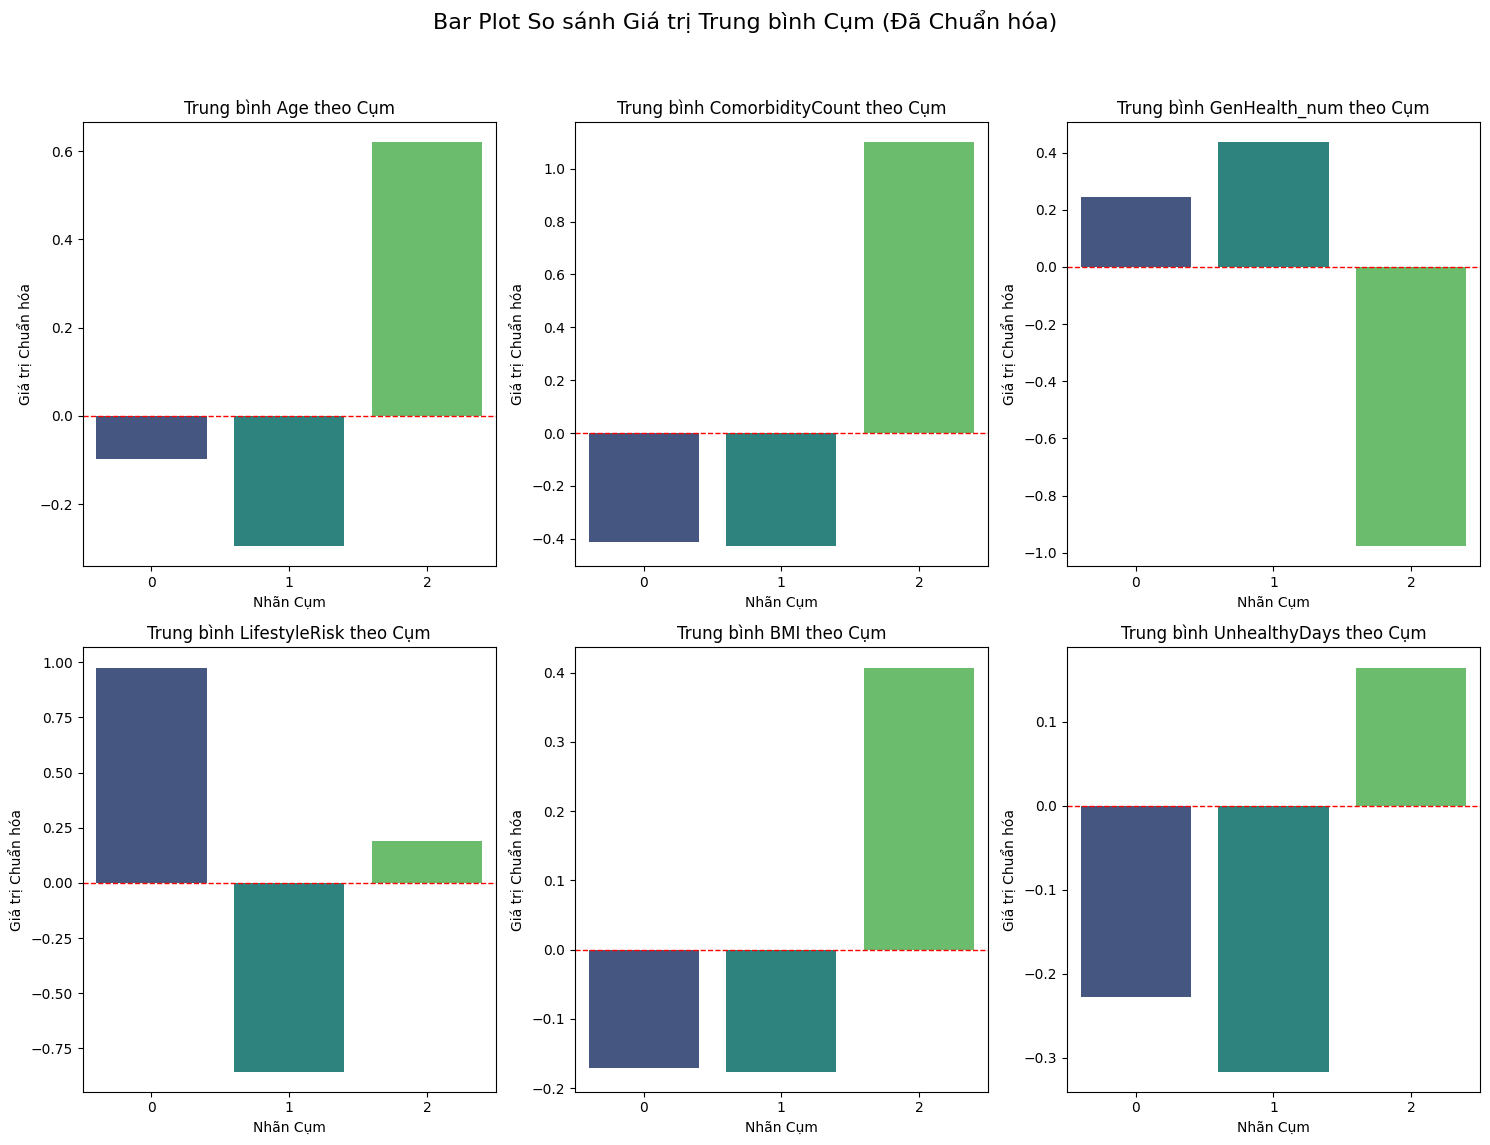

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

CORE_FEATURES = ['Age', 'ComorbidityCount', 'GenHealth_num', 'LifestyleRisk', 'BMI', 'UnhealthyDays']

plt.figure(figsize=(15, 12))
plt.suptitle('Bar Plot So sánh Giá trị Trung bình Cụm (Đã Chuẩn hóa)', fontsize=16)

for i, feature in enumerate(CORE_FEATURES):
    plt.subplot(2, 3, i + 1)

    sns.barplot(
        x='Cluster',
        y=feature,
        data=df_clustered_k4,
        palette='viridis',
        errorbar=None
    )
    plt.title(f'Trung bình {feature} theo Cụm')
    plt.xlabel('Nhãn Cụm')
    plt.ylabel('Giá trị Chuẩn hóa')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Box plot:**

/tmp/ipython-input-2944340789.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2944340789.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2944340789.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2944340789.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2944340789.py:12: FutureWarning: 

Passin

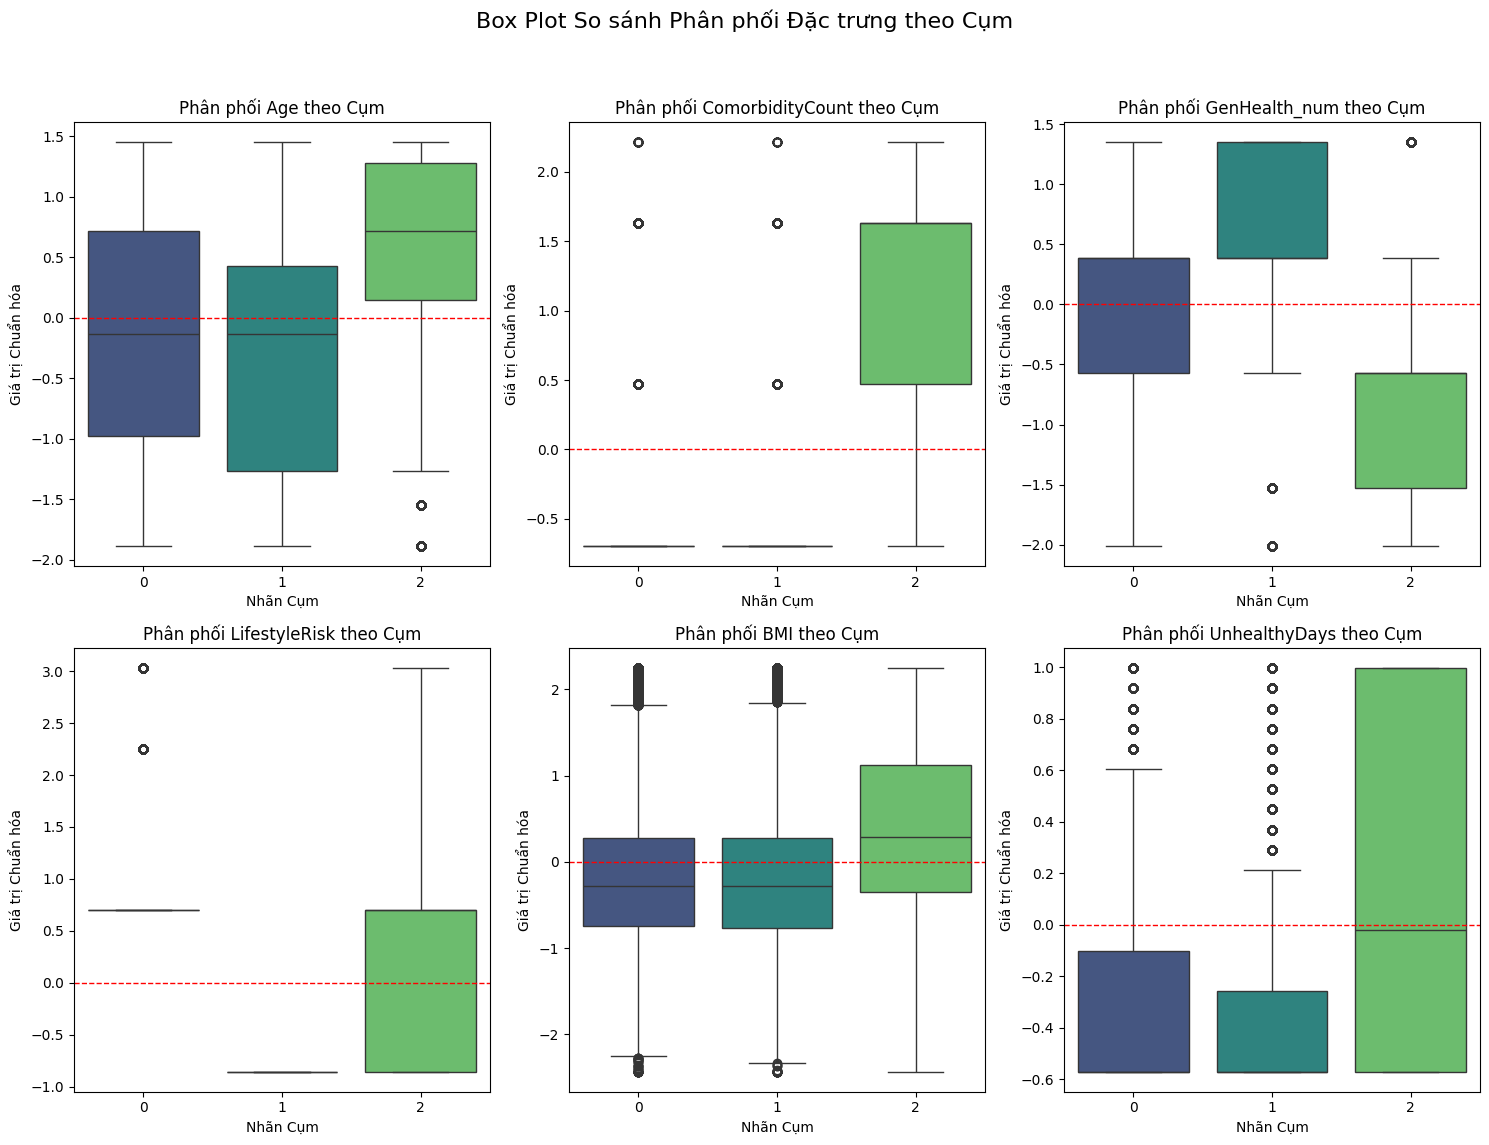

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

CORE_FEATURES = ['Age', 'ComorbidityCount', 'GenHealth_num', 'LifestyleRisk', 'BMI', 'UnhealthyDays']

plt.figure(figsize=(15, 12))
plt.suptitle('Box Plot So sánh Phân phối Đặc trưng theo Cụm', fontsize=16)

for i, feature in enumerate(CORE_FEATURES):
    plt.subplot(2, 3, i + 1)

    sns.boxplot(
        x='Cluster',
        y=feature,
        data=df_clustered_k4,
        palette='viridis'
    )
    plt.title(f'Phân phối {feature} theo Cụm')
    plt.xlabel('Nhãn Cụm')
    plt.ylabel('Giá trị Chuẩn hóa')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**PCA**

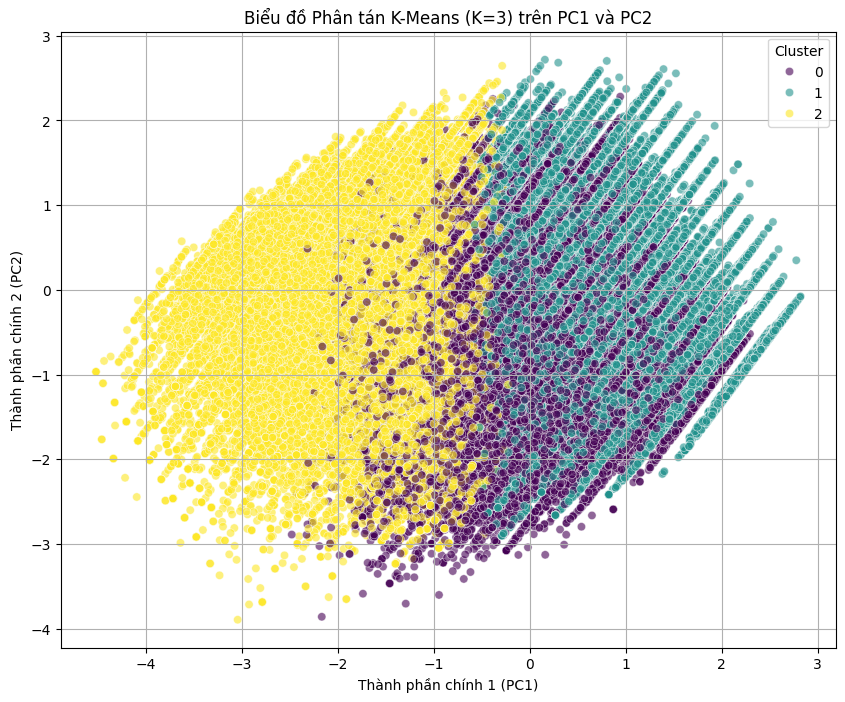

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# --- 1. Chuẩn bị Dữ liệu ---

# Lấy dữ liệu cho PCA (không bao gồm nhãn cụm)
X_data = df_clustered_k4.drop(columns=['Cluster'])

# --- 2. Giảm chiều bằng PCA xuống 2 components ---
pca_2d = PCA(n_components=2, random_state=42)
principal_components = pca_2d.fit_transform(X_data)

# Tạo DataFrame cho việc vẽ biểu đồ
pca_df = pd.DataFrame(data = principal_components,
                      columns = ['PC1', 'PC2'],
                      index=X_data.index)

# Thêm nhãn cụm vào DataFrame PCA
pca_df['Cluster'] = df_clustered_k4['Cluster']

# --- 3. Vẽ Biểu đồ Phân tán (Scatter Plot) ---

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    data=pca_df,
    legend='full',
    alpha=0.6
)
plt.title(f'Biểu đồ Phân tán K-Means (K=3) trên PC1 và PC2')
plt.xlabel(f'Thành phần chính 1 (PC1)')
plt.ylabel(f'Thành phần chính 2 (PC2)')
plt.grid(True)
plt.show()

**t-SNE**


--- Bắt đầu Trực quan hóa t-SNE (Đánh giá K=3) ---
Lưu ý: t-SNE rất tốn tài nguyên tính toán.
Đã lấy 30000 mẫu ngẫu nhiên từ 255836 điểm để chạy t-SNE.
Đang huấn luyện mô hình t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.049s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 30000 samples in 2.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sample 13000 / 30000
[t-SNE] Computed conditional probabilities for sample 14000 / 30000

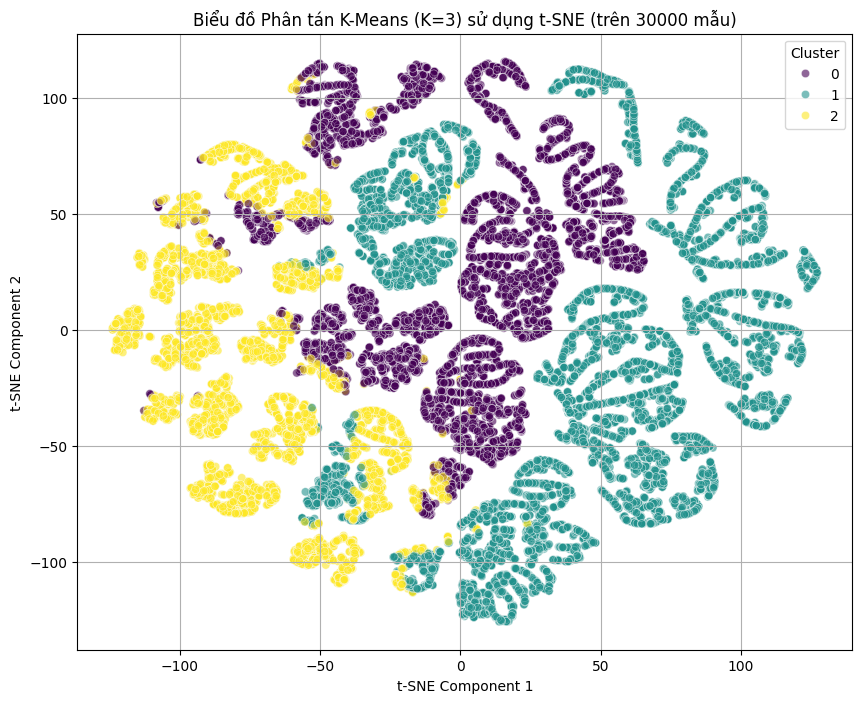

In [ ]:
[ ]
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import time

# --- 1. Thông báo về t-SNE ---
print("\n--- Bắt đầu Trực quan hóa t-SNE (Đánh giá K=3) ---")

# --- 2. Chuẩn bị Dữ liệu (Lấy mẫu) ---

SAMPLE_SIZE = 30000

if len(df_clustered_k4) > SAMPLE_SIZE:
    df_sample = df_clustered_k4.sample(n=SAMPLE_SIZE, random_state=42)
    print(f"Đã lấy {SAMPLE_SIZE} mẫu ngẫu nhiên từ {len(df_clustered_k4)} điểm để chạy t-SNE.")
else:
    df_sample = df_clustered_k4.copy()
    print(f"Sử dụng toàn bộ {len(df_clustered_k4)} điểm (vì kích thước < {SAMPLE_SIZE}).")

# Tách dữ liệu (X) và nhãn (y) từ mẫu
X_data_sample = df_sample.drop(columns=['Cluster'])
labels_sample = df_sample['Cluster']

# --- 3. Khởi tạo và Huấn luyện t-SNE ---
tsne_model = TSNE(
    n_components=2,     # Giảm xuống 2 chiều
    random_state=42,
    perplexity=30,
    init='pca',
    n_iter=1000,
    verbose=1
)

print("Đang huấn luyện mô hình t-SNE...")
start_time = time.time()
tsne_results = tsne_model.fit_transform(X_data_sample)
end_time = time.time()
print(f"Hoàn thành t-SNE sau {end_time - start_time:.2f} giây.")

# --- 4. Tạo DataFrame để Vẽ biểu đồ ---
tsne_df = pd.DataFrame(
    data=tsne_results,
    columns=['t-SNE 1', 't-SNE 2']
)
# Thêm nhãn cụm
tsne_df['Cluster'] = labels_sample.values

# --- 5. Vẽ Biểu đồ Phân tán (Scatter Plot) ---
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='t-SNE 1',
    y='t-SNE 2',
    hue='Cluster',
    palette='viridis',
    legend='full',
    alpha=0.6
)
plt.title(f'Biểu đồ Phân tán K-Means (K=3) sử dụng t-SNE (trên {SAMPLE_SIZE} mẫu)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

##GMM

Sử dụng 6 đặc trưng để phân cụm GMM.
Kích thước dữ liệu phân cụm: (255836, 6)

--- Bắt đầu Tính toán BIC/AIC để chọn số cụm cho GMM ---
Đã tính BIC/AIC cho K=1
Đã tính BIC/AIC cho K=2
Đã tính BIC/AIC cho K=3
Đã tính BIC/AIC cho K=4
Đã tính BIC/AIC cho K=5
Đã tính BIC/AIC cho K=6
Đã tính BIC/AIC cho K=7
Đã tính BIC/AIC cho K=8
Đã tính BIC/AIC cho K=9
Đã tính BIC/AIC cho K=10


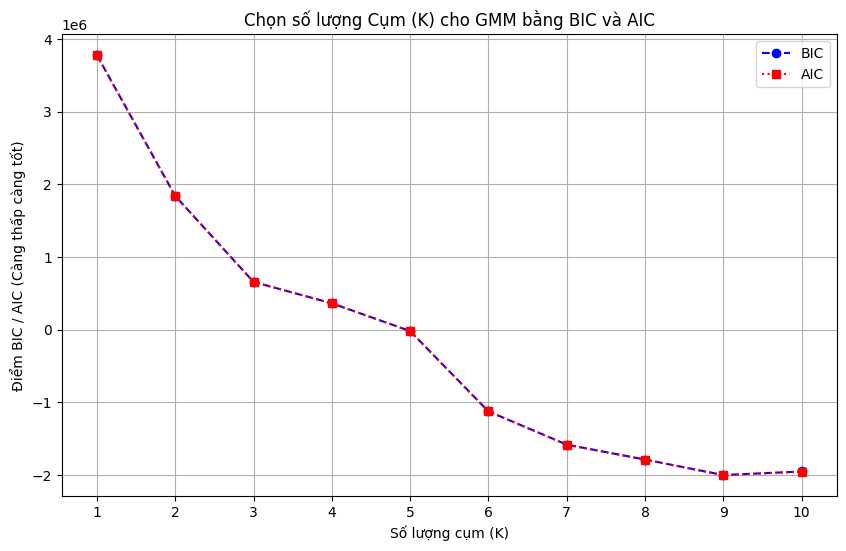

Số cụm tốt nhất dựa trên BIC (thấp nhất) là: 9
--- Sẽ tiến hành chạy với K=3 để so sánh với K-Means ---

Bắt đầu huấn luyện GMM với K = 3...
Hoàn thành GMM. Đã phân cụm thành 3 nhóm.
Kích thước của các cụm:
Cluster
0     19480
1    135509
2    100847
Name: count, dtype: int64

--- Đang tạo Heatmap Hồ sơ Cụm GMM ---


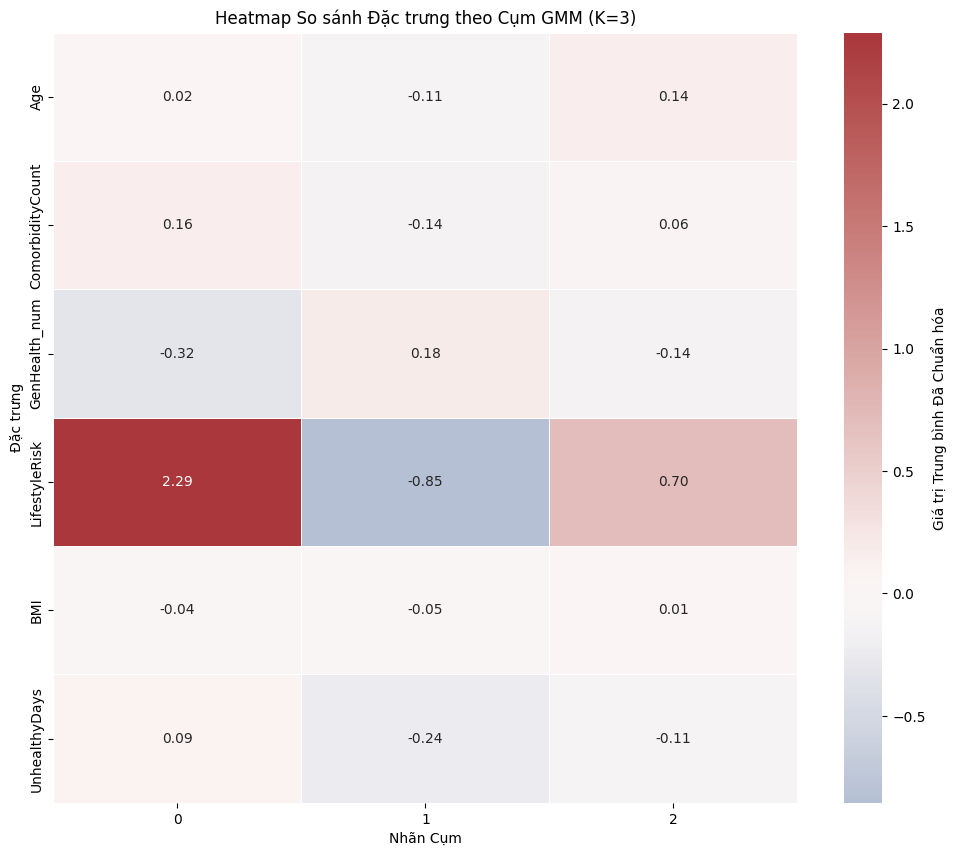


--- Đang tạo Bar Plots GMM ---


/tmp/ipython-input-4256188362.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4256188362.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4256188362.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4256188362.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4256188362.py:130: FutureWarning: 

P

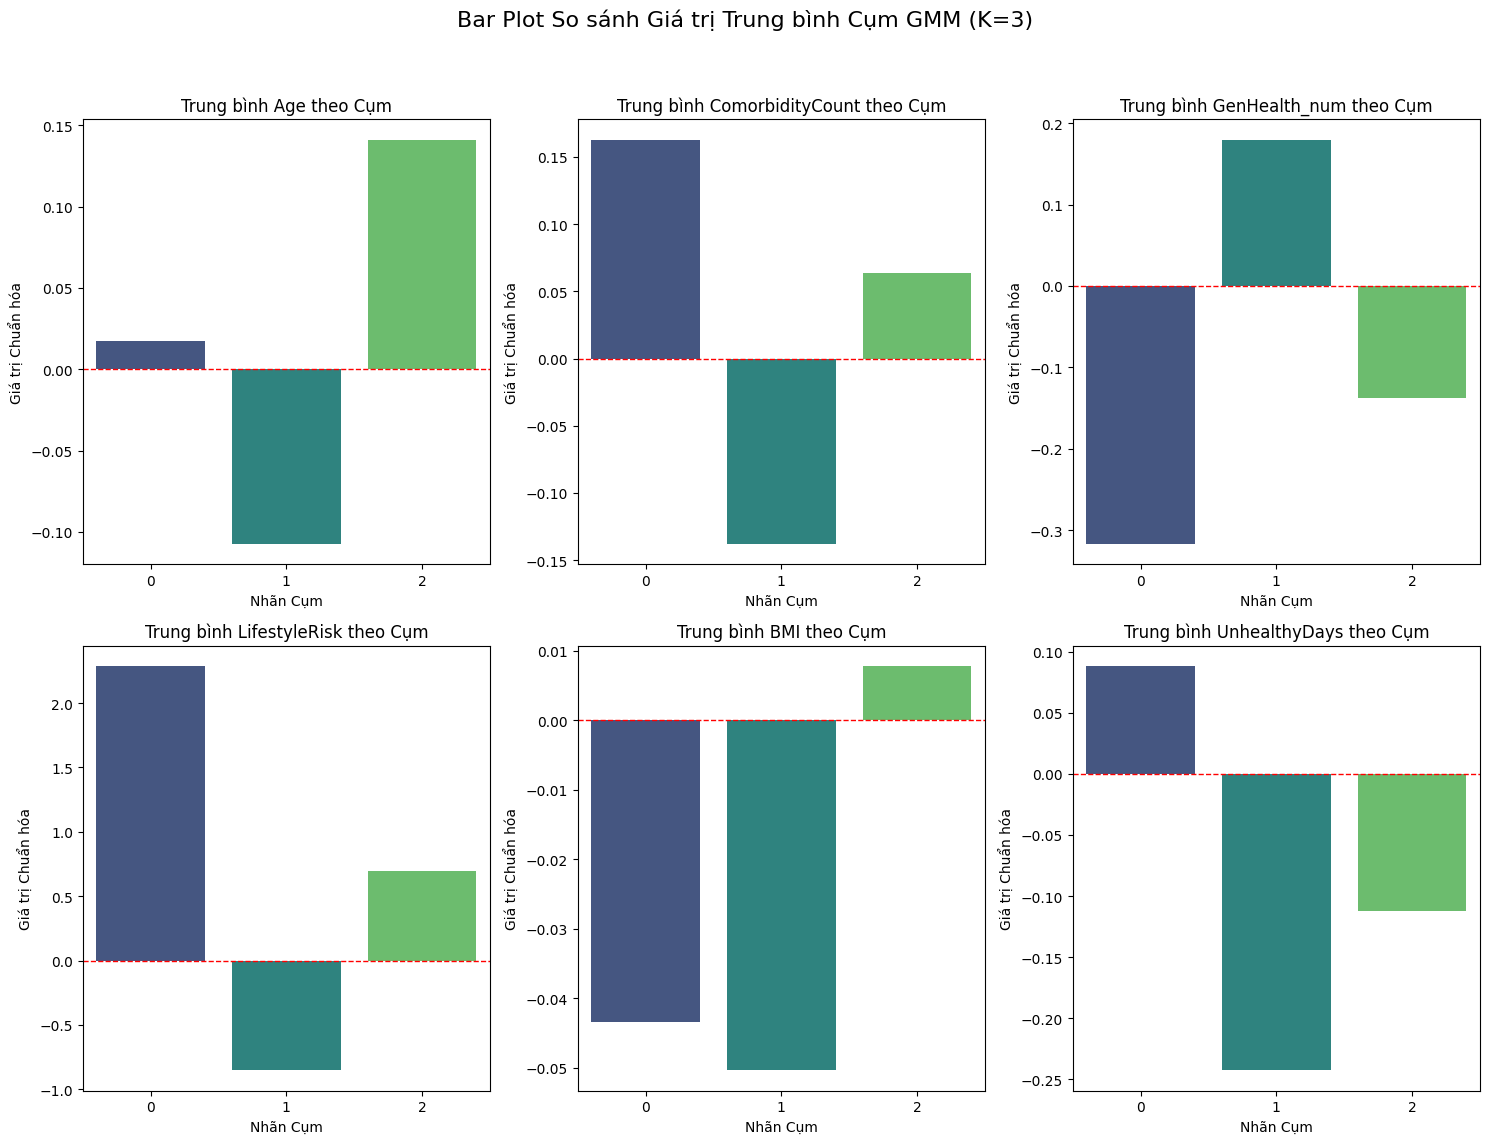


--- Đang tạo Box Plots GMM ---


/tmp/ipython-input-4256188362.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4256188362.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4256188362.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4256188362.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4256188362.py:153: FutureWarning: 

P

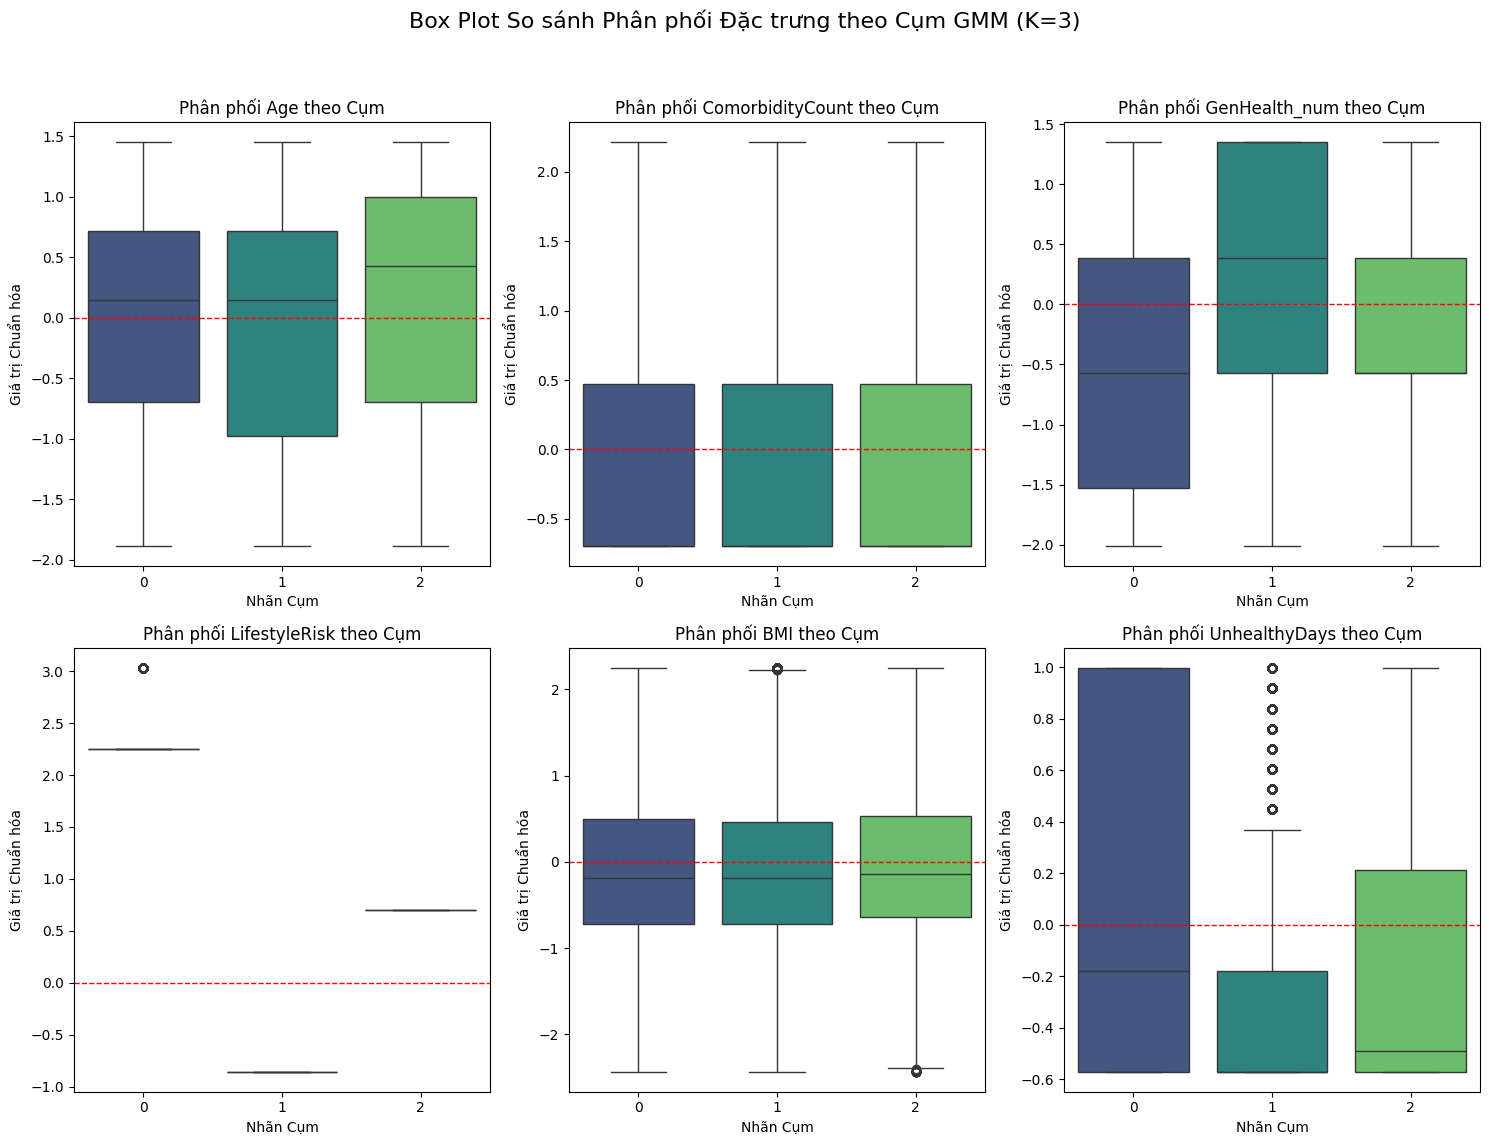


--- Đang tạo Trực quan hóa PCA cho GMM ---


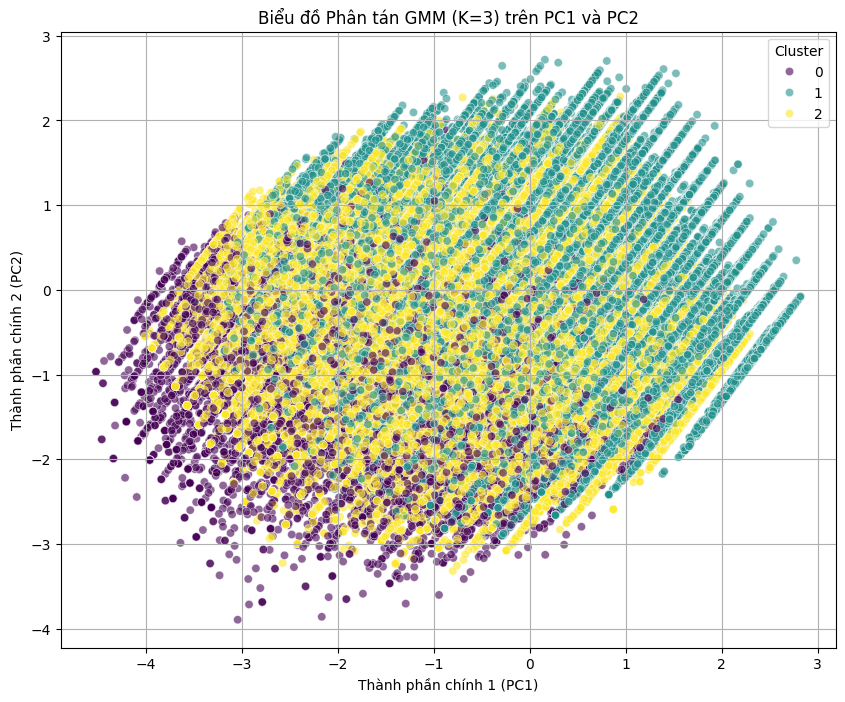


--- Bắt đầu Trực quan hóa t-SNE cho GMM ---
Đã lấy 30000 mẫu ngẫu nhiên để chạy t-SNE.
Đang huấn luyện mô hình t-SNE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Hoàn thành t-SNE sau 248.81 giây.


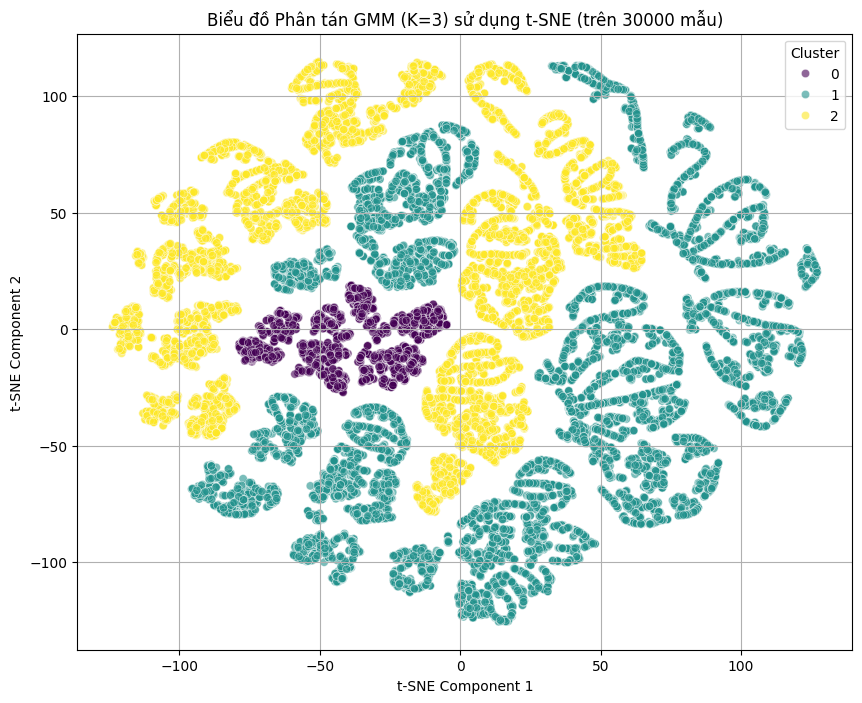


--- QUÁ TRÌNH GMM HOÀN TẤT ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- 1. CHUẨN BỊ DỮ LIỆU TỪ X_train_clean ---

CORE_FEATURES = ['Age', 'ComorbidityCount', 'GenHealth_num', 'LifestyleRisk', 'BMI', 'UnhealthyDays']
data_for_clustering = X_train_clean[CORE_FEATURES].copy()

print(f"Sử dụng {len(CORE_FEATURES)} đặc trưng để phân cụm GMM.")
print(f"Kích thước dữ liệu phân cụm: {data_for_clustering.shape}")


# --- 2. TÌM SỐ CỤM (K) BẰNG BIC/AIC ---
print("\n--- Bắt đầu Tính toán BIC/AIC để chọn số cụm cho GMM ---")

max_k = 11
n_components = range(1, max_k)
bic_scores = []
aic_scores = []

for i in n_components:
    gmm_bic = GaussianMixture(n_components=i,
                          random_state=42,
                          n_init=5,
                          covariance_type='full')
    gmm_bic.fit(data_for_clustering)

    bic_scores.append(gmm_bic.bic(data_for_clustering))
    aic_scores.append(gmm_bic.aic(data_for_clustering))
    print(f"Đã tính BIC/AIC cho K={i}")

# Vẽ biểu đồ BIC/AIC
plt.figure(figsize=(10, 6))
plt.plot(n_components, bic_scores, marker='o', linestyle='--', color='blue', label='BIC')
plt.plot(n_components, aic_scores, marker='s', linestyle=':', color='red', label='AIC')
plt.title('Chọn số lượng Cụm (K) cho GMM bằng BIC và AIC')
plt.xlabel('Số lượng cụm (K)')
plt.ylabel('Điểm BIC / AIC (Càng thấp càng tốt)')
plt.xticks(np.arange(1, max_k, 1))
plt.legend()
plt.grid(True)
plt.show()

# In ra điểm K có BIC thấp nhất
best_k_bic = n_components[np.argmin(bic_scores)]
print(f"Số cụm tốt nhất dựa trên BIC (thấp nhất) là: {best_k_bic}")
print("--- Sẽ tiến hành chạy với K=3 để so sánh với K-Means ---")


# --- 3. HÀM CHẠY GMM CLUSTERING ---
def run_gmm_clustering(data, k):
    """
    Thực hiện GMM Clustering và gán nhãn cụm cho dữ liệu.
    """
    print(f"\nBắt đầu huấn luyện GMM với K = {k}...")
    gmm_model = GaussianMixture(
        n_components=k,
        random_state=42,
        n_init=10,
        covariance_type='full'
    )

    cluster_labels = gmm_model.fit_predict(data)

    df_clustered = data.copy()
    df_clustered['Cluster'] = cluster_labels

    print(f"Hoàn thành GMM. Đã phân cụm thành {k} nhóm.")
    print(f"Kích thước của các cụm:\n{df_clustered['Cluster'].value_counts().sort_index()}")

    return df_clustered, gmm_model

# Chạy GMM với k=3
K_VALUE = 3
df_clustered_gmm, gmm_model = run_gmm_clustering(data_for_clustering, k=K_VALUE)


# --- 4. ĐÁNH GIÁ ĐỊNH TÍNH: HEATMAP HỒ SƠ CỤM ---
print("\n--- Đang tạo Heatmap Hồ sơ Cụm GMM ---")
cluster_profile_gmm = df_clustered_gmm.groupby('Cluster').mean()
profile_transposed_gmm = cluster_profile_gmm.T

plt.figure(figsize=(12, 10))
sns.heatmap(
    profile_transposed_gmm,
    cmap='vlag',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Giá trị Trung bình Đã Chuẩn hóa'}
)
plt.title(f'Heatmap So sánh Đặc trưng theo Cụm GMM (K={K_VALUE})')
plt.ylabel('Đặc trưng')
plt.xlabel('Nhãn Cụm')
plt.show()


# --- 5. ĐÁNH GIÁ ĐỊNH TÍNH: BAR PLOTS ---
print("\n--- Đang tạo Bar Plots GMM ---")
plt.figure(figsize=(15, 12))
plt.suptitle(f'Bar Plot So sánh Giá trị Trung bình Cụm GMM (K={K_VALUE})', fontsize=16)

for i, feature in enumerate(CORE_FEATURES):
    plt.subplot(2, 3, i + 1)
    sns.barplot(
        x='Cluster',
        y=feature,
        data=df_clustered_gmm,
        palette='viridis',
        errorbar=None
    )
    plt.title(f'Trung bình {feature} theo Cụm')
    plt.xlabel('Nhãn Cụm')
    plt.ylabel('Giá trị Chuẩn hóa')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 6. ĐÁNH GIÁ ĐỊNH TÍNH: BOX PLOTS ---
print("\n--- Đang tạo Box Plots GMM ---")
plt.figure(figsize=(15, 12))
plt.suptitle(f'Box Plot So sánh Phân phối Đặc trưng theo Cụm GMM (K={K_VALUE})', fontsize=16)

for i, feature in enumerate(CORE_FEATURES):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='Cluster',
        y=feature,
        data=df_clustered_gmm,
        palette='viridis'
    )
    plt.title(f'Phân phối {feature} theo Cụm')
    plt.xlabel('Nhãn Cụm')
    plt.ylabel('Giá trị Chuẩn hóa')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 7. TRỰC QUAN HÓA PCA ---
print("\n--- Đang tạo Trực quan hóa PCA cho GMM ---")
# Lấy dữ liệu (không bao gồm nhãn cụm)
X_data_pca = df_clustered_gmm.drop(columns=['Cluster'])

pca_2d = PCA(n_components=2, random_state=42)
principal_components = pca_2d.fit_transform(X_data_pca)

pca_df = pd.DataFrame(data=principal_components,
                      columns=['PC1', 'PC2'],
                      index=X_data_pca.index)
pca_df['Cluster'] = df_clustered_gmm['Cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    data=pca_df,
    legend='full',
    alpha=0.6
)
plt.title(f'Biểu đồ Phân tán GMM (K={K_VALUE}) trên PC1 và PC2')
plt.xlabel('Thành phần chính 1 (PC1)')
plt.ylabel('Thành phần chính 2 (PC2)')
plt.grid(True)
plt.show()


# --- 8. TRỰC QUAN HÓA t-SNE ---
print("\n--- Bắt đầu Trực quan hóa t-SNE cho GMM ---")
SAMPLE_SIZE = 30000

if len(df_clustered_gmm) > SAMPLE_SIZE:
    df_sample_tsne = df_clustered_gmm.sample(n=SAMPLE_SIZE, random_state=42)
    print(f"Đã lấy {SAMPLE_SIZE} mẫu ngẫu nhiên để chạy t-SNE.")
else:
    df_sample_tsne = df_clustered_gmm.copy()
    print(f"Sử dụng toàn bộ {len(df_clustered_gmm)} điểm.")

X_data_sample = df_sample_tsne.drop(columns=['Cluster'])
labels_sample = df_sample_tsne['Cluster']

tsne_model = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    init='pca',
    n_iter=1000,
    verbose=0
)

print("Đang huấn luyện mô hình t-SNE...")
start_time = time.time()
tsne_results = tsne_model.fit_transform(X_data_sample)
end_time = time.time()
print(f"Hoàn thành t-SNE sau {end_time - start_time:.2f} giây.")

tsne_df = pd.DataFrame(
    data=tsne_results,
    columns=['t-SNE 1', 't-SNE 2']
)
tsne_df['Cluster'] = labels_sample.values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='t-SNE 1',
    y='t-SNE 2',
    hue='Cluster',
    palette='viridis',
    data=tsne_df,
    legend='full',
    alpha=0.6
)
plt.title(f'Biểu đồ Phân tán GMM (K={K_VALUE}) sử dụng t-SNE (trên {SAMPLE_SIZE} mẫu)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

print("\n--- QUÁ TRÌNH GMM HOÀN TẤT ---")

# Prediction

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [ ]:
# --- Định nghĩa lại lớp MLP và các hàm hỗ trợ để cell này có thể chạy độc lập ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64, 32], dropout=0.0):
        super(MLP, self).__init__()
        layers = []
        in_features = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_features = h
        layers.append(nn.Linear(in_features, 1))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def to_tensor(X, y, device):
    X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1).to(device)
    return X_tensor, y_tensor

def train_mlp(model, X_train, y_train, lr=1e-3, epochs=10, batch_size=256, device="cpu", task_name="Training"):
    model.to(device)
    dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        progress_bar = tqdm(loader, desc=f"{task_name} - Epoch {epoch+1}/{epochs}")
        for X_batch, y_batch in progress_bar:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    return model

--- Phân tích Rủi ro Bệnh Tim ---


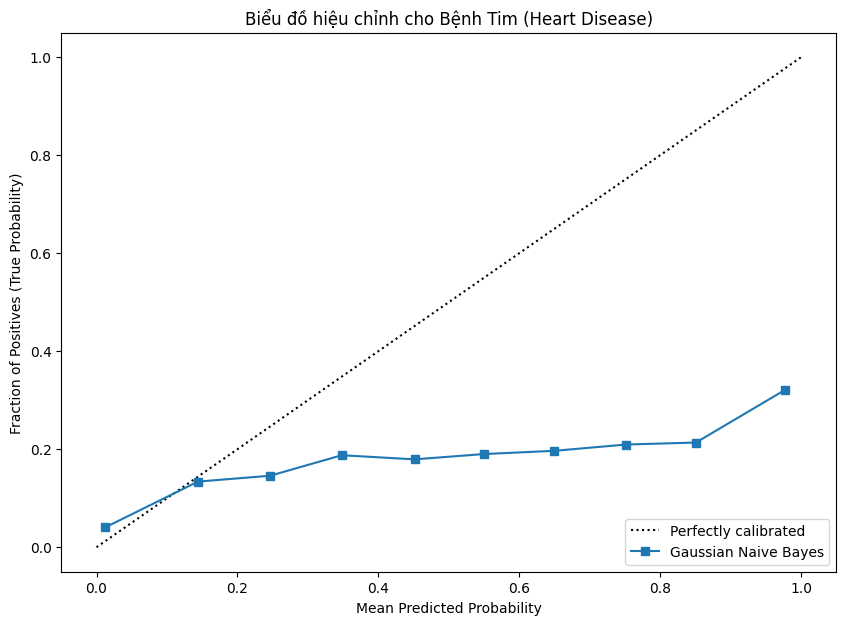

In [ ]:

# ==============================================================================
# 1. Bệnh Tim (HeartDisease) - Model tốt nhất: Gaussian Naive Bayes
# ==============================================================================
print("--- Phân tích Rủi ro Bệnh Tim ---")
# Huấn luyện lại model tốt nhất
nb_model_hd = GaussianNB(var_smoothing=1e-9)
nb_model_hd.fit(X_train_final, y_train)

# Dự đoán xác suất
prob_pos_hd = nb_model_hd.predict_proba(X_test_final)[:, 1]

# Vẽ biểu đồ hiệu chỉnh
fraction_of_positives_hd, mean_predicted_value_hd = calibration_curve(y_test, prob_pos_hd, n_bins=10)

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value_hd, fraction_of_positives_hd, "s-", label="Gaussian Naive Bayes")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives (True Probability)")
plt.legend(loc="lower right")
plt.title('Biểu đồ hiệu chỉnh cho Bệnh Tim (Heart Disease)')
plt.show()


--- Phân tích Rủi ro Ung thư da ---


SkinCancer MLP - Epoch 15/15: 100%|██████████| 1000/1000 [00:07<00:00, 128.61it/s]


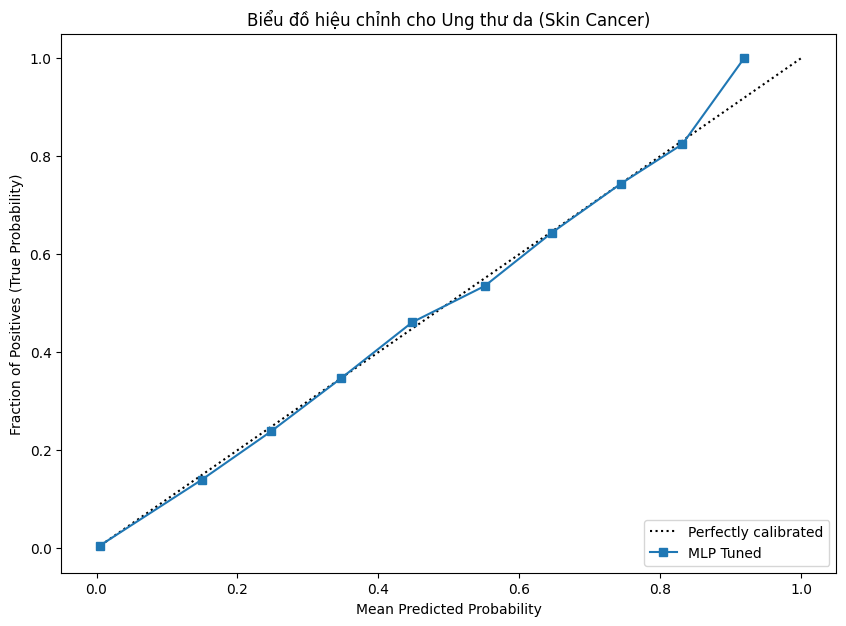

In [ ]:

# ==============================================================================
# 2. Ung thư da (SkinCancer) - Model tốt nhất: MLP Tuned
# ==============================================================================
print("\n--- Phân tích Rủi ro Ung thư da ---")
# Chuẩn bị dữ liệu
y_train_sc = X_train_final['SkinCancer']
X_train_sc = X_train_final.drop(columns=['SkinCancer'])
y_test_sc = X_test_final['SkinCancer']
X_test_sc = X_test_final.drop(columns=['SkinCancer'])

# Chuyển sang tensor
X_train_t_sc, y_train_t_sc = to_tensor(X_train_sc, y_train_sc, device)
X_test_t_sc, y_test_t_sc = to_tensor(X_test_sc, y_test_sc, device)

# Huấn luyện lại model tốt nhất
mlp_model_sc = MLP(X_train_sc.shape[1], hidden_layers=[128, 64, 32], dropout=0.2)
mlp_model_sc = train_mlp(mlp_model_sc, X_train_t_sc, y_train_t_sc, lr=5e-4, epochs=15, device=device, task_name="SkinCancer MLP")

# Dự đoán xác suất
with torch.no_grad():
    prob_pos_sc = mlp_model_sc(X_test_t_sc).cpu().numpy().flatten()

# Vẽ biểu đồ hiệu chỉnh
fraction_of_positives_sc, mean_predicted_value_sc = calibration_curve(y_test_sc, prob_pos_sc, n_bins=10)

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value_sc, fraction_of_positives_sc, "s-", label="MLP Tuned")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives (True Probability)")
plt.legend(loc="lower right")
plt.title('Biểu đồ hiệu chỉnh cho Ung thư da (Skin Cancer)')
plt.show()


--- Phân tích Rủi ro Hen suyễn ---


Asthma MLP - Epoch 15/15: 100%|██████████| 1000/1000 [00:07<00:00, 132.44it/s]


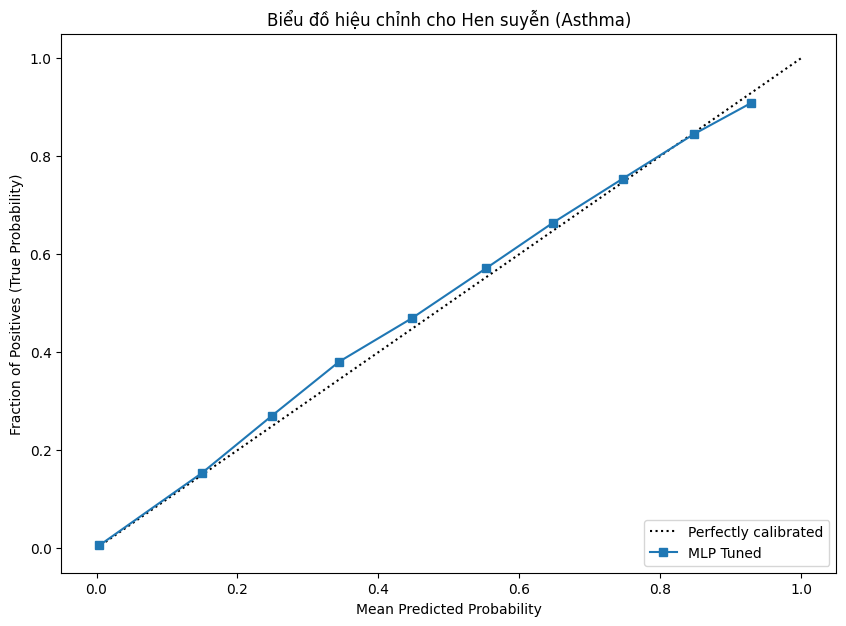

In [ ]:

# ==============================================================================
# 3. Hen suyễn (Asthma) - Model tốt nhất: MLP Tuned
# ==============================================================================
print("\n--- Phân tích Rủi ro Hen suyễn ---")
# Chuẩn bị dữ liệu
y_train_as = X_train_final['Asthma']
X_train_as = X_train_final.drop(columns=['Asthma'])
y_test_as = X_test_final['Asthma']
X_test_as = X_test_final.drop(columns=['Asthma'])

# Chuyển sang tensor
X_train_t_as, y_train_t_as = to_tensor(X_train_as, y_train_as, device)
X_test_t_as, y_test_t_as = to_tensor(X_test_as, y_test_as, device)

# Huấn luyện lại model tốt nhất
mlp_model_as = MLP(X_train_as.shape[1], hidden_layers=[128, 64, 32], dropout=0.2)
mlp_model_as = train_mlp(mlp_model_as, X_train_t_as, y_train_t_as, lr=5e-4, epochs=15, device=device, task_name="Asthma MLP")

# Dự đoán xác suất
with torch.no_grad():
    prob_pos_as = mlp_model_as(X_test_t_as).cpu().numpy().flatten()

# Vẽ biểu đồ hiệu chỉnh
fraction_of_positives_as, mean_predicted_value_as = calibration_curve(y_test_as, prob_pos_as, n_bins=10)

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value_as, fraction_of_positives_as, "s-", label="MLP Tuned")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives (True Probability)")
plt.legend(loc="lower right")
plt.title('Biểu đồ hiệu chỉnh cho Hen suyễn (Asthma)')
plt.show()

In [ ]:
# Sử dụng mô hình Naive Bayes đã huấn luyện để dự đoán xác suất trên tập test
prob_pos_hd = nb_model_hd.predict_proba(X_test_final)[:, 1]

# Tạo DataFrame results_df
results_df = pd.DataFrame({
    'Risk_Score': prob_pos_hd,
    'Actual_HeartDisease': y_test.values
})

# Hiển thị vài dòng đầu của DataFrame kết quả
print("DataFrame kết quả đã được tạo:")
display(results_df.head())

DataFrame kết quả đã được tạo:


Risk_Score  Actual_HeartDisease
0    0.107176                    0
1    0.790878                    0
2    0.012135                    0
3    0.168962                    0
4    0.002584                    0

In [ ]:
# SHAP
!pip install shap

import shap

# --- Phân tích Rủi ro Bệnh tim với SHAP ---
# 1. Chọn model tốt nhất (Naive Bayes cho Bệnh tim) và huấn luyện lại
nb_model_hd = GaussianNB(var_smoothing=1e-9)
nb_model_hd.fit(X_train_final, y_train)

# 2. Tạo SHAP Explainer
# Vì Naive Bayes không phải mô hình cây, ta dùng KernelExplainer
# Lấy một mẫu nhỏ (ví dụ 100 điểm) từ tập train để làm dữ liệu nền cho explainer
X_train_summary = shap.sample(X_train_final, 100)
explainer = shap.KernelExplainer(nb_model_hd.predict_proba, X_train_summary)

# 3. Tính toán giá trị SHAP cho tập test
shap_values = explainer.shap_values(X_test_final)

  0%|          | 0/63959 [00:00<?, ?it/s]

In [ ]:
# 4. Trực quan hóa lời giải thích cho một dự đoán cụ thể
# Chọn ra một bệnh nhân có rủi ro cao để phân tích
high_risk_patient_index = results_df['Risk_Score'].idxmax()

print(f"--- Phân tích chi tiết cho bệnh nhân có rủi ro cao nhất (Index: {high_risk_patient_index}) ---")
print(f"Điểm rủi ro dự đoán: {results_df.loc[high_risk_patient_index, 'Risk_Score']:.2%}")
print(f"Tình trạng thực tế: {'Có bệnh' if results_df.loc[high_risk_patient_index, 'Actual_HeartDisease'] == 1 else 'Không bệnh'}")

--- Phân tích chi tiết cho bệnh nhân có rủi ro cao nhất (Index: 328) ---
Điểm rủi ro dự đoán: 100.00%
Tình trạng thực tế: Có bệnh


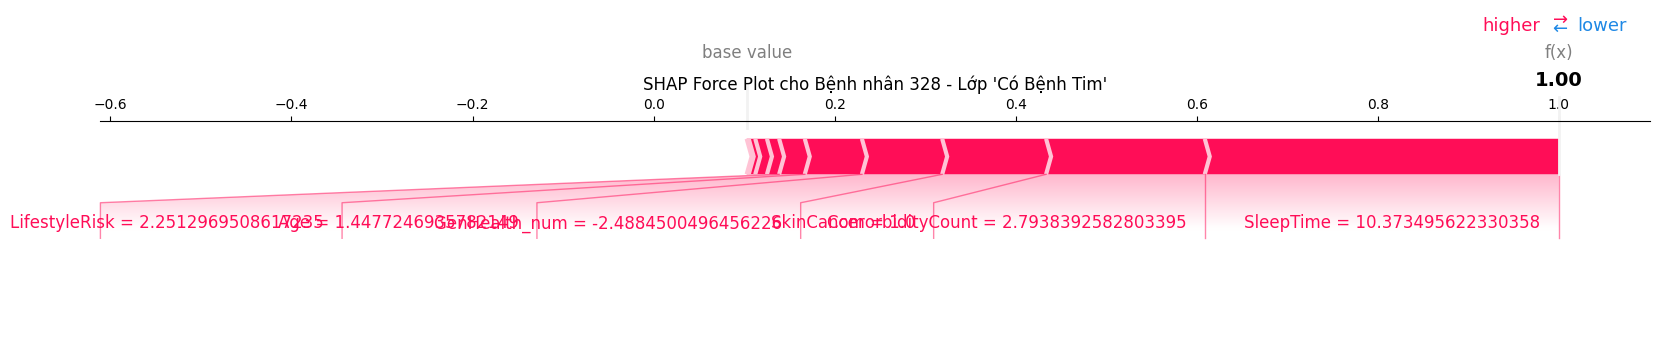

In [ ]:
shap.initjs()
shap_values_for_high_risk_patient = shap_values[high_risk_patient_index, :, 1]

# Lấy ra các giá trị đặc trưng của bệnh nhân đó
features_for_high_risk_patient = X_test_final.iloc[high_risk_patient_index, :]

# Vẽ biểu đồ force plot
shap.force_plot(
    explainer.expected_value[1],
    shap_values_for_high_risk_patient,
    features_for_high_risk_patient,
    matplotlib=True,
    show=False # Thêm tham số này để kiểm soát việc hiển thị
)
plt.title(f"SHAP Force Plot cho Bệnh nhân {high_risk_patient_index} - Lớp 'Có Bệnh Tim'", fontsize=12)
plt.show()

--- Phân tích cho bệnh nhân có rủi ro gần 50% nhất (Index: 22276) ---
Điểm rủi ro dự đoán: 50.00%
Tình trạng thực tế: Có bệnh
--------------------


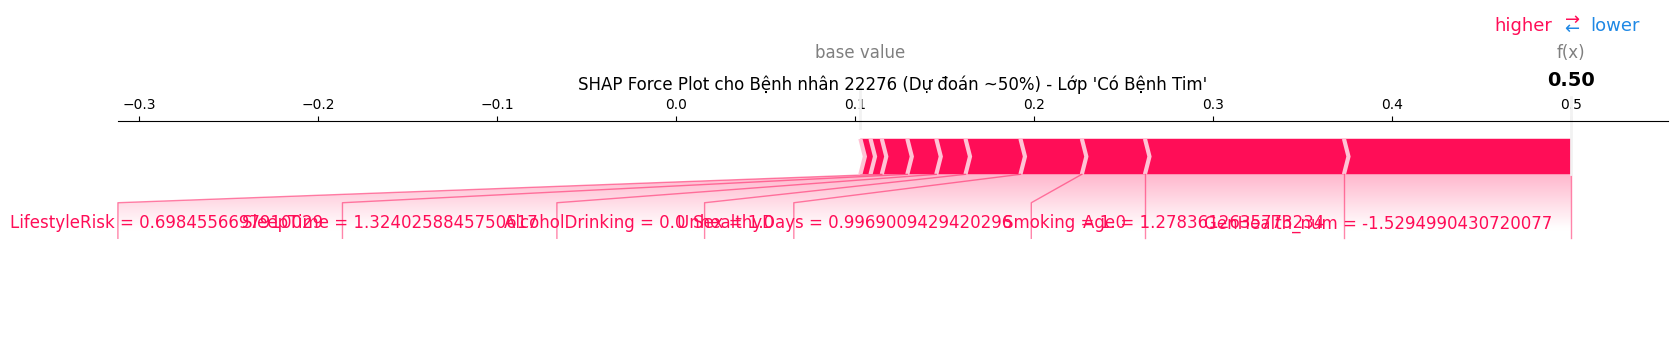

In [ ]:
target_probability = 0.5
patient_index_50_percent = (results_df['Risk_Score'] - target_probability).abs().idxmin()

risk_score = results_df.loc[patient_index_50_percent, 'Risk_Score']
actual_status = results_df.loc[patient_index_50_percent, 'Actual_HeartDisease']

print(f"--- Phân tích cho bệnh nhân có rủi ro gần 50% nhất (Index: {patient_index_50_percent}) ---")
print(f"Điểm rủi ro dự đoán: {risk_score:.2%}")
print(f"Tình trạng thực tế: {'Có bệnh' if actual_status == 1 else 'Không bệnh'}")
print("-" * 20)

shap.initjs()

# Giá trị SHAP cho lớp "Có bệnh" (lớp 1) của bệnh nhân này
shap_values_for_patient = shap_values[patient_index_50_percent, :, 1]

# Giá trị các đặc trưng của bệnh nhân này
features_for_patient = X_test_final.iloc[patient_index_50_percent, :]

# 3. Vẽ biểu đồ force plot
# explainer.expected_value[1] là giá trị kỳ vọng (base value) cho lớp 1
shap.force_plot(
    explainer.expected_value[1],
    shap_values_for_patient,
    features_for_patient,
    matplotlib=True,
    show=False
)
plt.title(f"SHAP Force Plot cho Bệnh nhân {patient_index_50_percent} (Dự đoán ~50%) - Lớp 'Có Bệnh Tim'", fontsize=12)
plt.show()

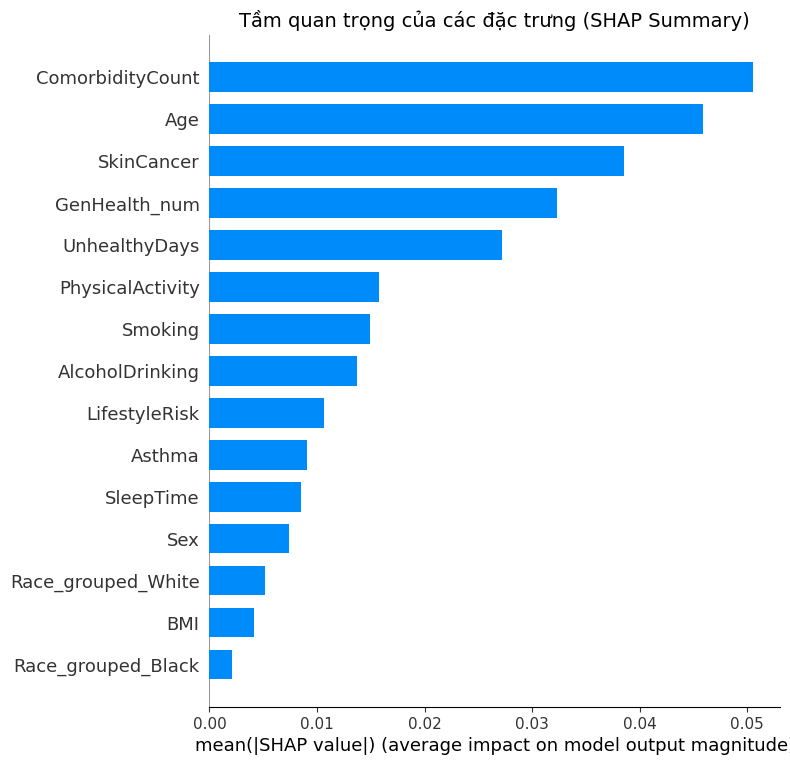

In [ ]:
shap.summary_plot(shap_values[:, :, 1], X_test_final, plot_type="bar", show=False)
plt.title("Tầm quan trọng của các đặc trưng (SHAP Summary)", fontsize=14)
plt.show()

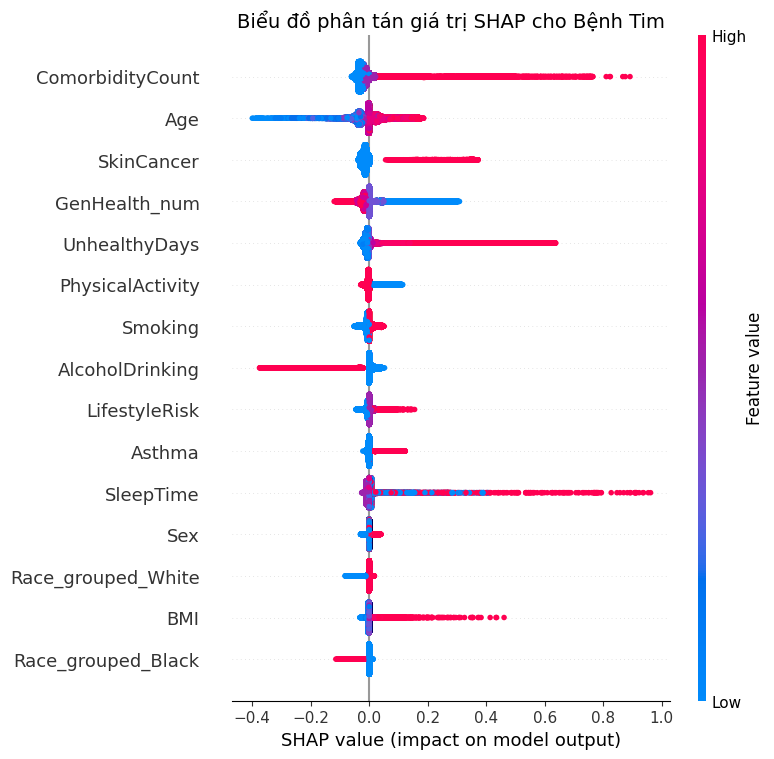

In [ ]:
shap.summary_plot(shap_values[:, :, 1], X_test_final, show=False)
plt.title("Biểu đồ phân tán giá trị SHAP cho Bệnh Tim", fontsize=14)
plt.show()

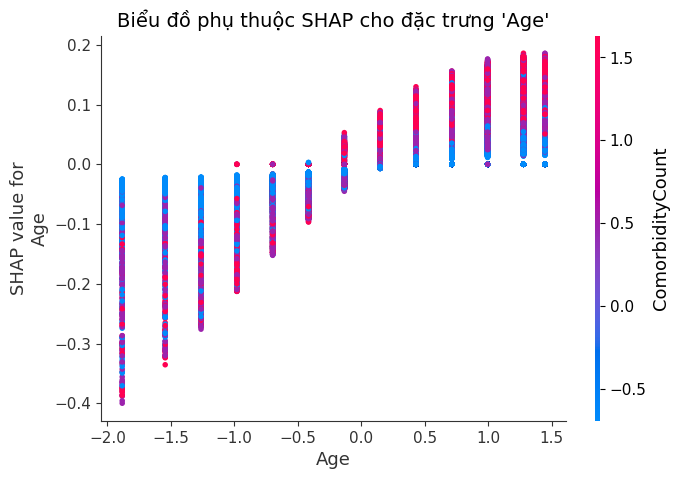

In [ ]:
shap.dependence_plot("Age", shap_values[:, :, 1], X_test_final, interaction_index="auto", show=False)
plt.title("Biểu đồ phụ thuộc SHAP cho đặc trưng 'Age'", fontsize=14)
plt.show()